In [2]:
library(ggplot2)
library(ggpubr)
library(corrplot)
library(RColorBrewer)
library(ggrepel)
library(argparse)
library(Matrix)
library(data.table)
library(dplyr)
library(circlize)
library(ggrepel)

options(bitmapType = 'cairo', device = 'png')
Sys.setlocale("LC_NUMERIC", "C")

setwd('/psycl/g/mpsziller/lucia/')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
functR <- sprintf('%sFunctions_prediction_plots.R', fold_notebook)
source(functR)

color_file <- sprintf('%scolor_tissues.txt', fold_notebook)
fold <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/'
fold_rep <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/Meta_Analysis_CAD/'
pheno <- 'CAD_HARD'
train_fold <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/train_GTEx/'
type_dat <- 'CAD_HARD-UKBB'
pval_FDR <- 0.05

# load results
color_tissues <- read.table(color_file, h=T, stringsAsFactors = F)
tscore <- fread(sprintf('%stscore_pval_%s_covCorr.txt', fold, pheno), 
                h=T, stringsAsFactors = F, sep = '\t', data.table = F)

pathR <- fread(sprintf('%spath_Reactome_pval_%s_covCorr_filt.txt', fold, pheno), 
               h=T, stringsAsFactors = F, sep = '\t', data.table = F)

pathGO <- fread(sprintf('%spath_GO_pval_%s_covCorr_filt.txt', fold, pheno), 
                h=T, stringsAsFactors = F, sep = '\t', data.table = F)

pathWiki <- fread(sprintf('%spath_WikiPath2019Human_pval_%s_covCorr_filt.txt', fold, pheno), 
                h=T, stringsAsFactors = F, sep = '\t', data.table = F)

tissues <- unique(tscore$tissue)
train_fold <- paste0(train_fold, tissues, '/200kb/CAD_GWAS_bin5e-2/')
# gwas runned on the same sample size and snp set
gwas_matched_file <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GWAS/CAD_UKBB_logistic_gwas_summary.txt'
out_fold <- sprintf('%sCAD_TWAS_PALAS/', fold_notebook)

# gene location
tscore$start_position <- NA
tscore$end_position <- NA
tscore$chrom <- NA
tscore$TSS_start <- NA
for(i in 1:length(train_fold)){
  tmp <- fread(sprintf('%s/resPrior_regEval_allchr.txt', train_fold[i]), h=T,stringsAsFactors = F, data.table = F)
  tmp <- tmp[match(tscore$ensembl_gene_id[tscore$tissue == tissues[i]], tmp$ensembl_gene_id),]
  tscore$start_position[tscore$tissue == tissues[i]] <- tmp$start_position
  tscore$end_position[tscore$tissue == tissues[i]] <- tmp$end_position
  tscore$chrom[tscore$tissue == tissues[i]] <- tmp$chrom
  tscore$TSS_start[tscore$tissue == tissues[i]] <- tmp$TSS_start   
}

# load loci and gwas res
tscore_loci <- fread(sprintf('%sGeneTscores_CADHARD_annotated.txt', fold), h=T, stringsAsFactors = F, sep = '\t', data.table = F)
gwas_res <- fread('refData/UKBB.GWAS1KG.EXOME.CAD.SOFT.META.PublicRelease.300517.txt.gz',  h=T, stringsAsFactors = F, sep = '\t', data.table = F)
colnames(gwas_res)[colnames(gwas_res) == 'p-value_gc'] <- 'p.value_gc'
gwas_res <- gwas_res[!is.na(gwas_res$chr), ]
# correct pvalues
gwas_res$pval_corr <- p.adjust(gwas_res$p.value_gc, method = 'BH')
gwas_res$chrom <- paste0('chr', gwas_res$chr)

# load gwas from matched sample/snps
gwas_matched <- fread(gwas_matched_file,  h=T, stringsAsFactors = F, sep = '\t', data.table = F)
gwas_matched$chrom <- paste0('chr', gwas_matched$CHROM)

# load gwas annotated with PriLer regulatory snps
regSNPs_gwas <- fread(sprintf('%smatched_GWAS_comparison/regSnps_annotated_CAD_UKBB_gwas.txt', fold), h=T, stringsAsFactors = F, data.table = F)

[1] "C"

In [3]:
#################################
### compare results with GWAS ###
#################################

ann_loci <- data.frame(loci_id = unique(tscore_loci$loci_complete), stringsAsFactors = F)
ann_loci$chr <- sapply(ann_loci$loci_id, function(x) strsplit(x, split = ':', fixed = T)[[1]][1])
tmp <- sapply(ann_loci$loci_id, function(x) strsplit(x, split = ':', fixed = T)[[1]][2])
ann_loci$start <- sapply(tmp, function(x) strsplit(x, split = '-', fixed = T)[[1]][1])
ann_loci$end <- sapply(tmp, function(x) strsplit(x, split = '-', fixed = T)[[1]][2])
ann_loci$best_GWAS_pval <- NA
ann_loci$best_GWAS_sign <- NA
ann_loci$best_GWAS_signBH <- NA

for(i in 1:nrow(ann_loci)){
   start_loci <- as.numeric(ann_loci$start[i])
   end_loci <- as.numeric(ann_loci$end[i])                
   id <- gwas_res$chrom == ann_loci$chr[i] & gwas_res$bp_hg19 <= end_loci & gwas_res$bp_hg19 >= start_loci
   tmp <- gwas_res[id, ]
   if(nrow(tmp)>0){
       ann_loci$best_GWAS_pval[i] <- min(tmp$p.value_gc)
       ann_loci$best_GWAS_sign[i] <- any(tmp$p.value_gc <= 5*10^-8)
       ann_loci$best_GWAS_signBH[i] <- any(tmp$pval_corr <= 0.05)     
   }
}


In [4]:
#########################################
### compare results with GWAS matched ###
#########################################

ann_loci$best_GWASm_pval <- NA
ann_loci$best_GWASm_sign <- NA
ann_loci$best_GWASm_signBH <- NA

for(i in 1:nrow(ann_loci)){
   start_loci <- as.numeric(ann_loci$start[i])
   end_loci <- as.numeric(ann_loci$end[i])                
   id <- gwas_matched$chrom == ann_loci$chr[i] & gwas_matched$POS <= end_loci & gwas_matched$POS >= start_loci
   tmp <- gwas_matched[id, ]
   if(nrow(tmp)>0){
       ann_loci$best_GWASm_pval[i] <- min(tmp$P)
       ann_loci$best_GWASm_sign[i] <- any(tmp$P <= 5*10^-8)
       ann_loci$best_GWASm_signBH[i] <- any(tmp$P_ADJ_BH <= 0.05)     
   }
}


In [5]:
# how many loci intersect significant GWAS results (Genomewide and BH correction)
table(ann_loci$best_GWAS_sign, ann_loci$best_GWAS_signBH)
# annotate gene table:
tscore_loci$best_GWAS_signBH <- NA
tscore_loci$best_GWAS_sign <- NA
tscore_loci$best_GWAS_pval <- NA
for(i in 1:nrow(ann_loci)){
    tscore_loci$best_GWAS_signBH[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_signBH[i]
    tscore_loci$best_GWAS_sign[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_sign[i]
    tscore_loci$best_GWAS_pval[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWAS_pval[i]
}


paste('unique new genes:', nrow(tscore_loci[!duplicated(tscore_loci$ensembl_gene_id) & !tscore_loci$best_GWAS_signBH,]))
paste('total new genes:', nrow(tscore_loci[!tscore_loci$best_GWAS_signBH,]))
paste('total new loci:', length(unique(tscore_loci$loci_complete[!tscore_loci$best_GWAS_signBH])))


       
        FALSE TRUE
  FALSE    33   26
  TRUE      0   24

[1] "unique new genes: 48"

[1] "total new genes: 92"

[1] "total new loci: 33"

In [6]:
# how many loci intersect significant GWAS matched results (Genomewide and BH correction)
table(ann_loci$best_GWASm_sign, ann_loci$best_GWASm_signBH)
# annotate gene table:
tscore_loci$best_GWASm_signBH <- NA
tscore_loci$best_GWASm_sign <- NA
tscore_loci$best_GWASm_pval <- NA
for(i in 1:nrow(ann_loci)){
    tscore_loci$best_GWASm_signBH[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWASm_signBH[i]
    tscore_loci$best_GWASm_sign[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWASm_sign[i]
    tscore_loci$best_GWASm_pval[tscore_loci$loci_complete == ann_loci$loci_id[i]] <- ann_loci$best_GWASm_pval[i]
}


paste('unique new genes:', nrow(tscore_loci[!duplicated(tscore_loci$ensembl_gene_id) & !tscore_loci$best_GWASm_signBH,]))
paste('total new genes:', nrow(tscore_loci[!tscore_loci$best_GWASm_signBH,]))
paste('total new loci:', length(unique(tscore_loci$loci_complete[!tscore_loci$best_GWASm_signBH])))


       
        FALSE TRUE
  FALSE    16   51
  TRUE      0   16

[1] "unique new genes: 20"

[1] "total new genes: 34"

[1] "total new loci: 16"

In [7]:
# new genes and loci from both matched and latest GWAS
paste('unique new genes:', nrow(tscore_loci[!duplicated(tscore_loci$ensembl_gene_id) & 
                                            !tscore_loci$best_GWASm_signBH 
                                            & !tscore_loci$best_GWAS_signBH,]))

paste('total new genes:', nrow(tscore_loci[!tscore_loci$best_GWASm_signBH 
                                           & !tscore_loci$best_GWAS_signBH,]))

paste('total new loci:', length(unique(tscore_loci$loci_complete[!tscore_loci$best_GWASm_signBH 
                                                                 & !tscore_loci$best_GWAS_signBH])))

tscore_loci[!tscore_loci$best_GWASm_signBH & !tscore_loci$best_GWAS_signBH,c('chrom', 'external_gene_name','loci', 'tissue', 'CAD_HARD_pval', 'CAD_HARD_z_t')]


[1] "unique new genes: 12"

[1] "total new genes: 19"

[1] "total new loci: 10"

chrom external_gene_name loci                tissue                  
34  chr20 MKRN7P             chr20:44.9-45.3Mb   Adipose_Subcutaneous    
60  chr20 ZNF663P            chr20:44.9-45.3Mb   Adipose_Visceral_Omentum
76  chr6  MYO6               chr6:76.3-76.7Mb    Adrenal_Gland           
86  chr20 ZNF663P            chr20:44.9-45.3Mb   Adrenal_Gland           
134 chr12 VSIG10             chr12:118.4-118.8Mb Artery_Aorta            
144 chr20 ZNF334             chr20:44.9-45.3Mb   Artery_Aorta            
149 chr1  ACP6               chr1:146.9-147.3Mb  Artery_Coronary         
172 chr20 ZNF334             chr20:44.9-45.3Mb   Artery_Coronary         
204 chr20 ZNF663P            chr20:44.9-45.3Mb   Colon_Sigmoid           
266 chr20 ZNF334             chr20:44.9-45.3Mb   Heart_Atrial_Appendage  
283 chr5  AC034220.3         chr5:131.5-131.9Mb  Heart_Left_Ventricle    
284 chr5  SPATA24            chr5:138.5-138.9Mb  Heart_Left_Ventricle    
292 chr10 DUPD1              chr10:76.6-77Mb     Heart_Left_Ventricle    
298 chr12 OR7E47P            chr12:52.3-52.7Mb   Heart_Left_Ventricle    
307 chr20 MKRN7P             chr20:44.9-45.3Mb   Heart_Left_Ventricle    
308 chr20 ZNF334             chr20:44.9-45.3Mb   Heart_Left_Ventricle    
318 chr1  ACP6               chr1:146.9-147.3Mb  Liver                   
335 chr14 SYNJ2BP-COX16      chr14:70.7-71.1Mb   Liver                   
379 chr20 OSER1              chr20:42.6-43Mb     Whole_Blood             
    CAD_HARD_pval CAD_HARD_z_t
34  2.614921e-04  -3.650734   
60  2.422616e-04  -3.670305   
76  2.716532e-04  -3.640932   
86  3.184157e-04  -3.599838   
134 1.552053e-04  -3.782589   
144 5.267376e-04  -3.466778   
149 4.550308e-04  -3.505921   
172 5.998180e-04  -3.431697   
204 5.333836e-04  -3.463406   
266 1.890932e-04  -3.733159   
283 2.607906e-04  -3.651424   
284 3.641304e-04  -3.564802   
292 6.268272e-04  -3.419733   
298 1.380409e-04   3.811652   
307 3.587736e-04  -3.568688   
308 4.673556e-04  -3.498801   
318 6.062339e-04  -3.428810   
335 6.932771e-06   4.495742   
379 2.784586e-04  -3.634557

In [8]:
# add replication
tscore_repl <- fread(sprintf('%stscore_pval_Dx_covCorr.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
rep_df <- data.frame(CardioGram_beta = c(), CardioGram_se_beta =c(), CardioGram_z =c(),
                    CardioGram_pval =c(), CardioGram_pval_BHcorr =c(), CardioGram_Cochran_stat =c(),
                    CardioGram_Cochran_pval =c(), CardioGram_model = c(), stringsAsFactors = F)

for(i in 1:nrow(tscore_loci)){
    
    tmp <- tscore_repl[tscore_repl$ensembl_gene_id == tscore_loci$ensembl_gene_id[i] & tscore_repl$tissue == tscore_loci$tissue[i],]
    new <- data.frame(CardioGram_beta = tmp$Dx_beta, CardioGram_se_beta =tmp$Dx_se_beta, CardioGram_z =tmp$Dx_z,
                    CardioGram_pval =tmp$Dx_pval, CardioGram_pval_BHcorr =tmp$Dx_pval_BHcorr, 
                      CardioGram_Cochran_stat =tmp$Dx_Cochran_stat,
                    CardioGram_Cochran_pval =tmp$Dx_Cochran_pval, CardioGram_model = tmp$Dx_model,  stringsAsFactors = F)
    rep_df <- rbind(rep_df,new)
}
tscore_complete <- cbind(tscore_loci, rep_df)
tscore_complete$replicated <- NA
tscore_complete$replicated <- sign(tscore_complete$CAD_HARD_z_t * tscore_complete$CardioGram_z)==1
table(tscore_complete$replicated, !tscore_complete$best_GWAS_signBH)

new_repl <- tscore_complete[!tscore_complete$best_GWAS_signBH & tscore_complete$replicated & tscore_complete$CardioGram_pval <= 0.05,
                c('chrom', 'external_gene_name','loci', 'tissue', 'CAD_HARD_pval', 'CAD_HARD_z_t', 'CardioGram_pval','CardioGram_z','replicated')]
length(unique(new_repl$loci))
new_repl[order(new_repl$loci),]


# remove mathced gwas reuslts
# tscore_complete <- tscore_complete %>% select(-c(best_GWASm_signBH, best_GWASm_sign, best_GWASm_pval))
# save
write.table(tscore_complete, file = sprintf('%sGeneTscores_CADHARD_annotated_intGWAS_withReplication.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)


# without nominal replication
new_repl_notnom <- tscore_complete[!tscore_complete$best_GWAS_signBH & tscore_complete$replicated,
                c('chrom', 'external_gene_name','loci', 'tissue', 'CAD_HARD_pval', 'CAD_HARD_z_t', 'CardioGram_pval','CardioGram_z','replicated')]
length(unique(new_repl_notnom$loci))
new_repl_notnom
# use OSER1 as example: 1) no GWAS significant, 2) more dev_geno in test with priors, 
# 3) 6 SNPs but different subset prior/noprior (only 2 in common) 4) however single SNPs more significant!

# or use OR7E47P 1) no GWAS significant AND more sign than SNPs  2) more dev_geno in test with priors, 
# 4) 88 vs 91 and 85 in common, more prior info

# tscore_complete[tscore_complete$external_gene_name == 'OR7E47P',c('best_GWAS_pval', 'best_GWASm_pval')]

       
        FALSE TRUE
  FALSE    37   33
  TRUE    254   59

[1] 11

chrom external_gene_name loci               tissue                  
63  chr1  ATP1B1             chr1:168.9-169.5Mb Adrenal_Gland           
92  chr1  NME7               chr1:168.9-169.5Mb Artery_Aorta            
177 chr1  NME7               chr1:168.9-169.5Mb Colon_Sigmoid           
208 chr1  NME7               chr1:168.9-169.5Mb Colon_Transverse        
298 chr12 OR7E47P            chr12:52.3-52.7Mb  Heart_Left_Ventricle    
29  chr15 CTD-2262B20.1      chr15:85.8-86.2Mb  Adipose_Subcutaneous    
30  chr16 RP11-407G23.4      chr16:57.1-57.5Mb  Adipose_Subcutaneous    
84  chr17 FAM20A             chr17:66.3-66.8Mb  Adrenal_Gland           
98  chr2  MAP3K2             chr2:127.7-128.3Mb Artery_Aorta            
211 chr2  BIN1               chr2:127.7-128.3Mb Colon_Transverse        
243 chr2  ERCC3              chr2:127.7-128.3Mb Heart_Atrial_Appendage  
43  chr2  NFU1               chr2:69.5-69.9Mb   Adipose_Visceral_Omentum
379 chr20 OSER1              chr20:42.6-43Mb    Whole_Blood             
66  chr3  ALG1L              chr3:125.4-126Mb   Adrenal_Gland           
156 chr3  ALG1L              chr3:125.4-126Mb   Artery_Coronary         
186 chr3  ALG1L              chr3:125.4-126Mb   Colon_Sigmoid           
213 chr3  RP11-124N2.1       chr3:125.4-126Mb   Colon_Transverse        
246 chr3  ALG1L              chr3:125.4-126Mb   Heart_Atrial_Appendage  
277 chr3  ALG1L              chr3:125.4-126Mb   Heart_Left_Ventricle    
278 chr3  RP11-666A20.3      chr3:125.4-126Mb   Heart_Left_Ventricle    
355 chr3  ALG1L              chr3:125.4-126Mb   Whole_Blood             
160 chr3  FNDC3B             chr3:171.6-172Mb   Artery_Coronary         
120 chr7  IGFBP3             chr7:45.8-46.2Mb   Artery_Aorta            
    CAD_HARD_pval CAD_HARD_z_t CardioGram_pval CardioGram_z replicated
63  3.134178e-04   3.603950    6.782846e-03     2.707322    TRUE      
92  8.315375e-05  -3.935124    3.383281e-03    -2.930582    TRUE      
177 4.248872e-04  -3.524123    3.826846e-03    -2.892093    TRUE      
208 8.488568e-05  -3.930170    4.136809e-03    -2.867537    TRUE      
298 1.380409e-04   3.811652    3.040734e-02     2.164743    TRUE      
29  2.504570e-04   3.661792    7.969579e-03     2.653356    TRUE      
30  2.064329e-05  -4.257817    9.554376e-03    -2.591553    TRUE      
84  1.070258e-05   4.402469    2.738668e-02     2.205962    TRUE      
98  4.979708e-04   3.481846    8.391695e-06     4.454939    TRUE      
211 6.926833e-05   3.978785    1.034511e-02     2.564075    TRUE      
243 5.738399e-04  -3.443687    3.874994e-05    -4.114809    TRUE      
43  3.145251e-05   4.162687    2.532944e-02     2.236341    TRUE      
379 2.784586e-04  -3.634557    4.683332e-02    -1.987804    TRUE      
66  1.435744e-04  -3.801928    1.423083e-02    -2.451383    TRUE      
156 6.725689e-05  -3.985787    1.205337e-02    -2.510578    TRUE      
186 3.044326e-05  -4.170125    1.855013e-02    -2.354450    TRUE      
213 3.808274e-04   3.553026    2.454542e-02     2.248483    TRUE      
246 1.201518e-04  -3.845816    7.904283e-03    -2.656131    TRUE      
277 1.097006e-04  -3.868069    1.130471e-02    -2.533136    TRUE      
278 4.708662e-04  -3.496805    3.572013e-02    -2.100099    TRUE      
355 2.867626e-04  -3.626974    2.947294e-02    -2.177102    TRUE      
160 9.041403e-05   3.914974    3.722798e-02     2.083255    TRUE      
120 4.427863e-04  -3.513175    4.022620e-02    -2.051419    TRUE

[1] 27

chrom external_gene_name loci                tissue                  
7   chr3  ALS2CL             chr3:46.5-46.9Mb    Adipose_Subcutaneous    
29  chr15 CTD-2262B20.1      chr15:85.8-86.2Mb   Adipose_Subcutaneous    
30  chr16 RP11-407G23.4      chr16:57.1-57.5Mb   Adipose_Subcutaneous    
32  chr18 LMAN1              chr18:56.8-57.2Mb   Adipose_Subcutaneous    
42  chr1  COA6               chr1:234.3-234.9Mb  Adipose_Visceral_Omentum
43  chr2  NFU1               chr2:69.5-69.9Mb    Adipose_Visceral_Omentum
63  chr1  ATP1B1             chr1:168.9-169.5Mb  Adrenal_Gland           
64  chr1  COA6               chr1:234.3-234.9Mb  Adrenal_Gland           
65  chr3  FAM86JP            chr3:125.4-126Mb    Adrenal_Gland           
66  chr3  ALG1L              chr3:125.4-126Mb    Adrenal_Gland           
67  chr3  RP11-666A20.3      chr3:125.4-126Mb    Adrenal_Gland           
69  chr6  RP1-13D10.2        chr6:16-16.4Mb      Adrenal_Gland           
83  chr14 CKB                chr14:103.8-104.2Mb Adrenal_Gland           
84  chr17 FAM20A             chr17:66.3-66.8Mb   Adrenal_Gland           
92  chr1  NME7               chr1:168.9-169.5Mb  Artery_Aorta            
95  chr1  COA6               chr1:234.3-234.9Mb  Artery_Aorta            
98  chr2  MAP3K2             chr2:127.7-128.3Mb  Artery_Aorta            
120 chr7  IGFBP3             chr7:45.8-46.2Mb    Artery_Aorta            
122 chr8  BMP1               chr8:21.8-22.2Mb    Artery_Aorta            
136 chr14 RP11-894P9.2       chr14:103.8-104.2Mb Artery_Aorta            
149 chr1  ACP6               chr1:146.9-147.3Mb  Artery_Coronary         
150 chr1  COA6               chr1:234.3-234.9Mb  Artery_Coronary         
155 chr3  FAM86JP            chr3:125.4-126Mb    Artery_Coronary         
156 chr3  ALG1L              chr3:125.4-126Mb    Artery_Coronary         
160 chr3  FNDC3B             chr3:171.6-172Mb    Artery_Coronary         
171 chr17 PRKAR1A            chr17:66.3-66.8Mb   Artery_Coronary         
177 chr1  NME7               chr1:168.9-169.5Mb  Colon_Sigmoid           
181 chr1  COA6               chr1:234.3-234.9Mb  Colon_Sigmoid           
185 chr3  FAM86JP            chr3:125.4-126Mb    Colon_Sigmoid           
186 chr3  ALG1L              chr3:125.4-126Mb    Colon_Sigmoid           
208 chr1  NME7               chr1:168.9-169.5Mb  Colon_Transverse        
211 chr2  BIN1               chr2:127.7-128.3Mb  Colon_Transverse        
213 chr3  RP11-124N2.1       chr3:125.4-126Mb    Colon_Transverse        
228 chr8  RP11-320N21.2      chr8:95.9-96.3Mb    Colon_Transverse        
229 chr11 HMBS               chr11:118.7-119.4Mb Colon_Transverse        
233 chr13 SMAD9              chr13:37.3-37.7Mb   Colon_Transverse        
234 chr18 LMAN1              chr18:56.8-57.2Mb   Colon_Transverse        
241 chr1  COA6               chr1:234.3-234.9Mb  Heart_Atrial_Appendage  
243 chr2  ERCC3              chr2:127.7-128.3Mb  Heart_Atrial_Appendage  
245 chr3  FAM86JP            chr3:125.4-126Mb    Heart_Atrial_Appendage  
246 chr3  ALG1L              chr3:125.4-126Mb    Heart_Atrial_Appendage  
256 chr7  TBX20              chr7:35.1-35.5Mb    Heart_Atrial_Appendage  
271 chr1  COA6               chr1:234.3-234.9Mb  Heart_Left_Ventricle    
272 chr1  RP5-855F14.1       chr1:234.3-234.9Mb  Heart_Left_Ventricle    
275 chr3  ALS2CL             chr3:46.5-46.9Mb    Heart_Left_Ventricle    
276 chr3  FAM86JP            chr3:125.4-126Mb    Heart_Left_Ventricle    
277 chr3  ALG1L              chr3:125.4-126Mb    Heart_Left_Ventricle    
278 chr3  RP11-666A20.3      chr3:125.4-126Mb    Heart_Left_Ventricle    
282 chr5  SETD9              chr5:56-56.4Mb      Heart_Left_Ventricle    
283 chr5  AC034220.3         chr5:131.5-131.9Mb  Heart_Left_Ventricle    
292 chr10 DUPD1              chr10:76.6-77Mb     Heart_Left_Ventricle    
298 chr12 OR7E47P            chr12:52.3-52.7Mb   Heart_Left_Ventricle    
303 chr16 RP5-991G20.1       chr16:72.5-72.9Mb   Heart_Left_Ventricle    
318 chr1

Replicated genes that would not be detected by GWAS output: 59 across 27 loci, at the nominal replication level: 23 genes across 11 loci.

Plot exemplar result for OR7E47P in Heart Left Ventricle --> Beta, prior info

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



AdiposeNuclei          dMES 
            3             4 

0 1 2 
4 3 2 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”
Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



AdiposeNuclei          dMES 
            1             2 

0 1 
6 3 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


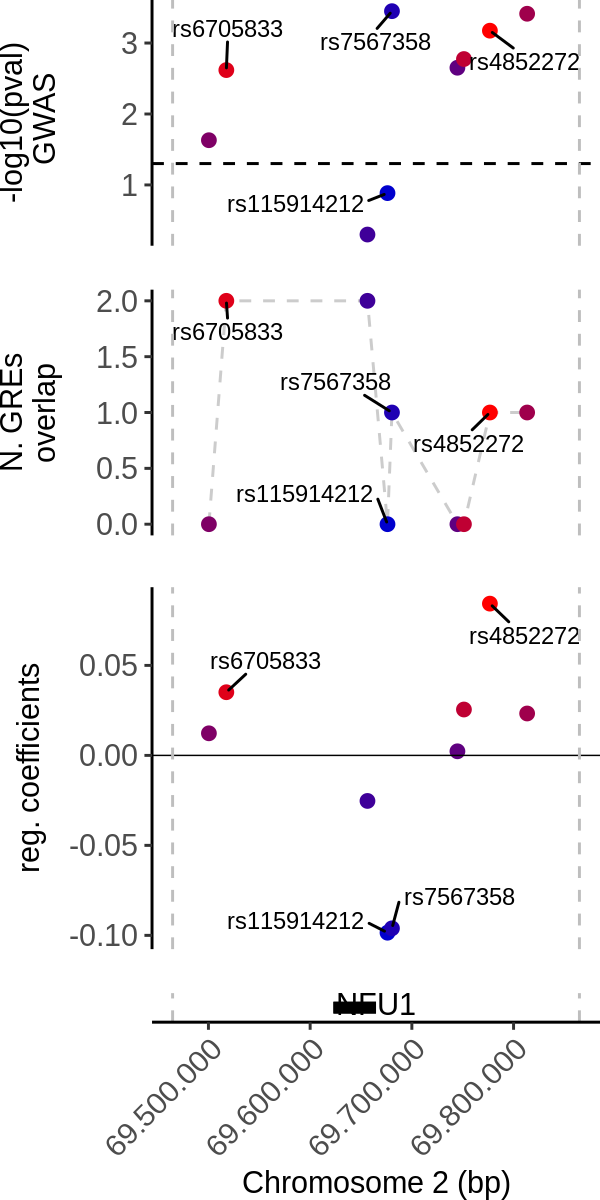

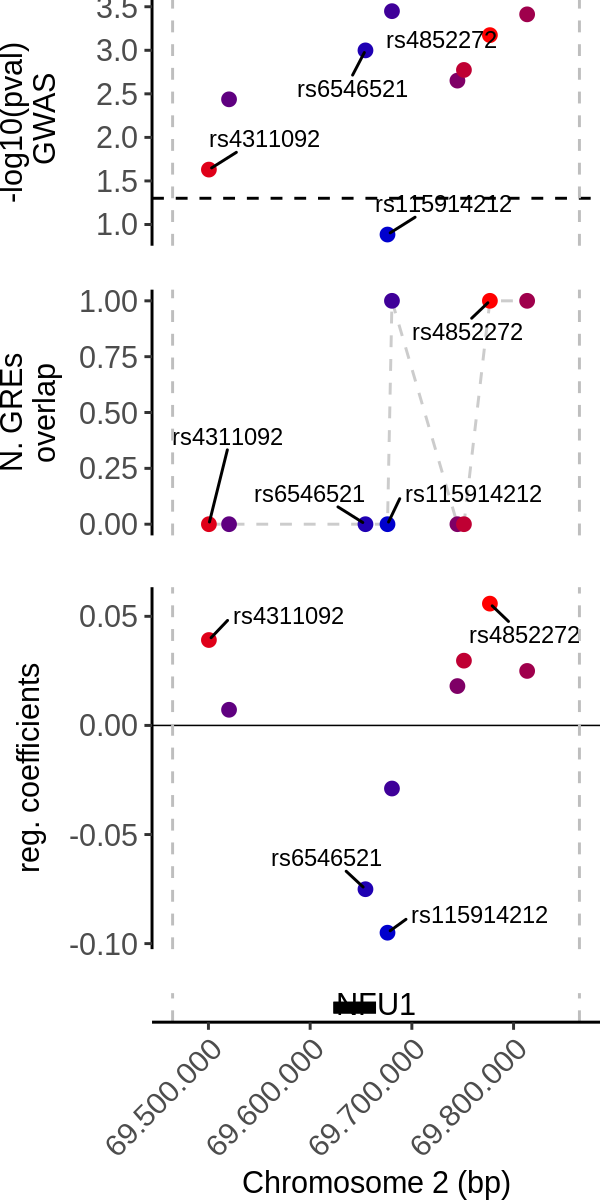

In [9]:
########################################################
#### plot results for a gene regulation from PriLer ####
########################################################

options(repr.plot.width = 3, repr.plot.height = 6, repr.plot.res = 200)

gene_chosen <- 'NFU1'
tissue <- 'Adipose_Visceral_Omentum'
prior_fold <- '/psycl/g/mpsziller/lucia/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/'
prior_id_file <- sprintf('%s%s/priorName_CADgwas_withIndex.txt', prior_fold, tissue)
id_tissue <- which(tissues == tissue)

pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_matched, ID_name = 'ID_CAD', prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = T, tscore = tscore_complete, n_show_rs = 4)
pl_tot$plot


ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)


pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_matched, ID_name = 'ID_CAD', prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = F, tscore = tscore_complete, n_show_rs = 4)
pl_tot$plot

                     
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_enet_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_enet_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)

                     
            

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



                 CD56_mesoderm                 colonic_mucosa 
                             8                              9 
               Duodenum_mucosa                  rectal_mucosa 
                             8                             11 
          rectal_smooth_muscle                        gastric 
                             5                              4 
large_intestine_fetal_day108_M small_intestine_fetal_day108_M 
                             7                             11 

 0  2  4  5  8 
38  2  2  7  2 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


pos      name       val           id    col     label     
1  21817777 rs4345650  -0.0418904205 46615 #0F00C0           
2  21842733 rs10113948 -0.0119631896 46653 #51008B           
3  21844772 rs11532907 -0.0233849601 46658 #3300A4           
4  21846327 rs7851133   0.0093725409 46661 #E00018           
5  21851157 rs10965161  0.0079920459 46667 #DB001C           
6  21855038 rs3802393  -0.0560953387 46677 #0500C8 rs3802393 
7  21857244 rs7047648   0.0325591503 46681 #EA0010           
8  21866313 rs1418072   0.0021719802 46691 #C6002D           
9  21866500 rs2027484   0.0020337009 46692 #BC0035           
10 21871050 rs4977737   0.0005714770 46695 #9E004D           
11 21887874 rs12236836  0.0013698782 46706 #B2003D           
12 21895053 rs10118406  0.0007117996 46715 #AD0041           
13 21898997 rs11531716  0.0007112219 46721 #A80045           
14 22019732 rs10757264  0.0417936348 46777 #F40008           
15 22020493 rs490005   -0.0262441844 46778 #2800AC           
16 22021172 rs597816   -0.0762400626 46779 #0000CD rs597816  
17 22041998 rs17694493 -0.0222664030 46818 #38009F           
18 22048414 rs7028268  -0.0139936891 46828 #4C008F           
19 22064465 rs8181047  -0.0029985816 46862 #990052           
20 22065002 rs10811647 -0.0236566127 46863 #2D00A8           
21 22065657 rs1333039  -0.0086290767 46864 #7A006A           
22 22067004 rs10965223 -0.0274805584 46866 #2300B0           
23 22067276 rs10965224 -0.0104873217 46867 #5B0083           
24 22067542 rs10811648 -0.0098126008 46868 #66007B           
25 22067554 rs10811649 -0.0087542496 46869 #75006E           
26 22067593 rs10811650 -0.0204469421 46870 #3D009B           
27 22068652 rs4977756  -0.0087676891 46872 #6B0076           
28 22072264 rs10757269 -0.0179672569 46875 #420097           
29 22072301 rs9632884  -0.0417376931 46876 #1400BC           
30 22072638 rs9632885  -0.0426125387 46877 #0A00C4           
31 22076795 rs10757271 -0.0101384799 46880 #60007F           
32 22077085 rs10811652 -0.0067567296 46881 #8E005A           
33 22077543 rs1412832  -0.0335316795 46882 #1900B8           
34 22087473 rs7857345  -0.0324562472 46888 #1E00B4           
35 22103341 rs1537373  -0.0085019924 46899 #7F0066           
36 22103813 rs1333042  -0.0178981275 46900 #470093           
37 22105927 rs7859362  -0.0116071421 46901 #560087           
38 22112241 rs7341786  -0.0079118534 46906 #840062           
39 22112427 rs7341791  -0.0087627729 46907 #700072           
40 22144255 rs2151285  -0.0041084446 46949 #930056           
41 22148055 rs12341394 -0.0067968007 46954 #89005E           
42 22148702 rs72656724  0.0591468809 46955 #F90004 rs72656724
43 22152643 rs6475613   0.0647802148 46962 #FF0000 rs6475613 
44 22153360 rs7853123   0.0020580122 46964 #C10031           
45 22153714 rs7853621   0.0019840684 46966 #B70039           
46 22154009 rs7045424   0.0023185684 46967 #CC0028           
47 22158598 rs10738611  0.0045752576 46974 #D10024           
48 22159416 rs10757288  0.0006663848 46976 #A30049           
49 22162238 rs1333053   0.0270055821 46987 #E50014           
50 22164991 rs10811668  0.0077062201 46993 #D60020           
51 22173676 rs9987689   0.0388500619 47014 #EF000C

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



CD14_primary_cells CD19_primary_cells  CD3_primary_cells CD56_primary_cells 
                 5                  8                  9                  6 
           GM12878              HUVEC 
                 3                  6 

 0  2  3  4  6 
36  3  1  4  2 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


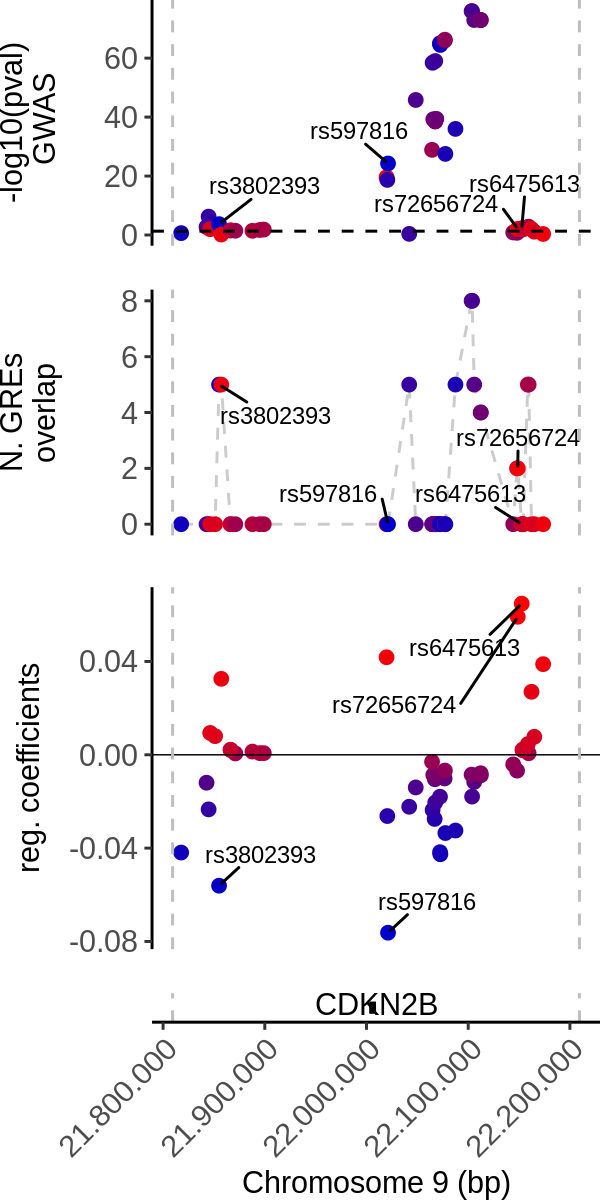

pos      name        val           id    col     label     
1  21816758 rs7023954   -0.0104600840 46613 #3E009A           
2  21840298 rs10811629  -0.0037204414 46645 #930056           
3  21846727 rs6475591    0.0114151745 46662 #E20016           
4  21864098 rs10117507  -0.0085202641 46685 #6B0076           
5  21864535 rs3802394   -0.0084635227 46687 #710071           
6  21865106 rs4977735   -0.0032256569 46688 #9E004D           
7  21995882 rs2518723   -0.0245508383 46747 #2200B1           
8  21995941 rs78545330  -0.0687025215 46748 #0000CD rs78545330
9  21998035 rs2811712    0.0064823515 46750 #CC0028           
10 21998139 rs3218018   -0.0006824268 46751 #C6002D           
11 21999800 rs3218007   -0.0055531757 46754 #8D005B           
12 22000247 rs3218005   -0.0068523126 46755 #7C0068           
13 22000841 rs3218002   -0.0070651888 46756 #77006D           
14 22006273 rs2069426   -0.0502822421 46760 #0B00C3 rs2069426 
15 22006348 rs974336    -0.0510114830 46761 #0500C8 rs974336  
16 22008026 rs2069422    0.0412742615 46762 #F90004           
17 22012441 rs77920300  -0.0063830633 46766 #88005F           
18 22025432 rs116729641 -0.0033784356 46789 #990052           
19 22025885 rs77284052  -0.0032064613 46791 #A40048           
20 22027551 rs598664     0.0074869519 46797 #DD001B           
21 22030438 rs662463     0.0449683633 46804 #FF0000 rs662463  
22 22033824 rs79985856  -0.0018696910 46809 #AF003F           
23 22034267 rs79182326  -0.0019303552 46810 #AA0044           
24 22040839 rs76213463  -0.0166378743 46815 #2700AD           
25 22041155 rs80166549  -0.0166300009 46816 #2D00A8           
26 22044059 rs1333035    0.0073664197 46823 #D7001F           
27 22044122 rs1333034    0.0072690934 46824 #D10024           
28 22054690 rs7874604    0.0172095600 46846 #F30009           
29 22057530 rs77728904  -0.0325049215 46852 #1600BA           
30 22059061 rs115574830 -0.0338877619 46853 #1100BF           
31 22060833 rs77283072  -0.0099068079 46856 #440096           
32 22062134 rs1011970   -0.0094788945 46860 #4F008D           
33 22124504 rs1333047    0.0141346770 46925 #EE000D           
34 22124744 rs4977575    0.0132747772 46927 #E80012           
35 22129579 rs7020996   -0.0067968172 46931 #820064           
36 22132076 rs2383208   -0.0141724424 46934 #38009F           
37 22132698 rs10965246  -0.0094940721 46935 #490091           
38 22132729 rs10965247  -0.0014505968 46936 #B5003B           
39 22132878 rs10965248  -0.0089011296 46937 #550088           
40 22133284 rs10965250  -0.0086546636 46938 #60007F           
41 22134068 rs10811660  -0.0085245149 46939 #66007B           
42 22134094 rs10811661  -0.0088257294 46940 #5A0084           
43 22144305 rs2151283   -0.0009782462 46950 #BB0036           
44 22153714 rs7853621   -0.0144416347 46966 #3300A4           
45 22159416 rs10757288  -0.0309777814 46976 #1C00B6           
46 22162560 rs6475616   -0.0007683118 46988 #C00032

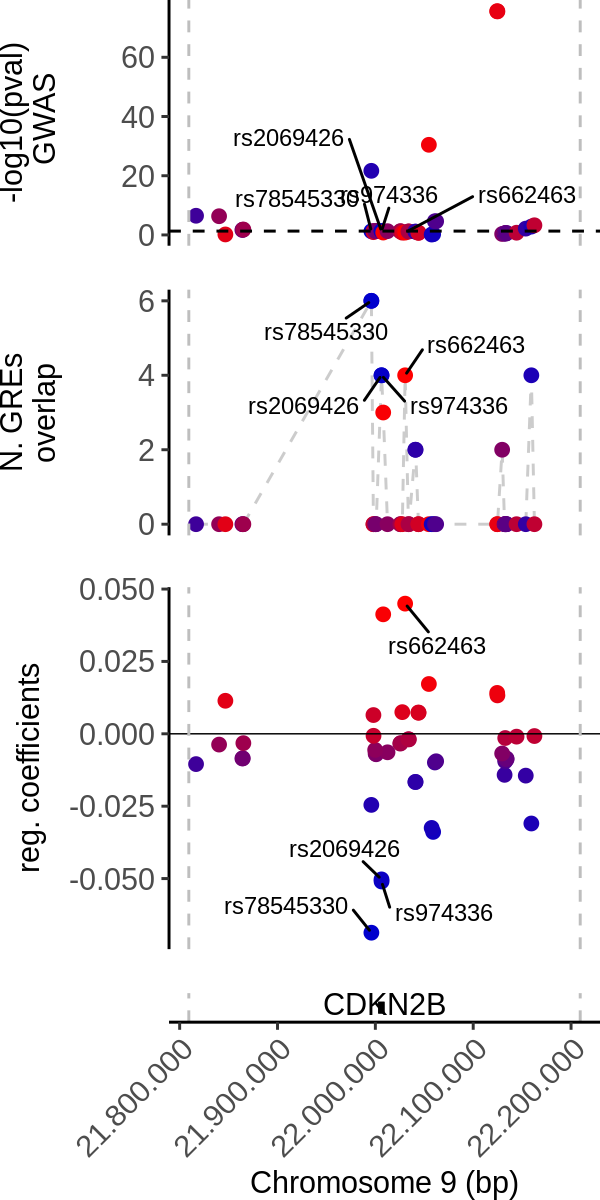

In [10]:
options(repr.plot.width = 3, repr.plot.height = 6, repr.plot.res = 200)
source(functR)

gene_chosen <- 'CDKN2B'
tissue <- 'Colon_Sigmoid'
prior_fold <- '/psycl/g/mpsziller/lucia/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/'
prior_id_file <- sprintf('%s%s/priorName_CADgwas_withIndex.txt', prior_fold, tissue)
id_tissue <- which(tissues == tissue)

pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_matched, ID_name = 'ID_CAD', prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = T, tscore = tscore_complete, n_show_rs = 4)
pl_tot$plot
pl_tot$beta_reg
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_CS_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_CS_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)

tissue <- 'Whole_Blood'
prior_fold <- '/psycl/g/mpsziller/lucia/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/'
prior_id_file <- sprintf('%s%s/priorName_CADgwas_withIndex.txt', prior_fold, tissue)
id_tissue <- which(tissues == tissue)

pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_matched, ID_name = 'ID_CAD', prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = T, tscore = tscore, n_show_rs = 4)
pl_tot$plot
pl_tot$beta_reg
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_WB_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_WB_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)




Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



          CD56_mesoderm             heart_aorta    heart_left_ventricle 
                      0                       0                       0 
     heart_right_atrium   heart_right_ventricle CAD_H3K27ac_ATAC_merged 
                      0                       0                       2 

0 1 
1 2 


Warning message:
“Use of `df_pos$start_gene` is discouraged. Use `start_gene` instead.”
Warning message:
“Use of `df_pos$end_gene` is discouraged. Use `end_gene` instead.”
Warning message in prettyNum(.Internal(format(x, trim, digits, nsmall, width, 3L, :
“'big.mark' and 'decimal.mark' are both '.', which could be confusing”


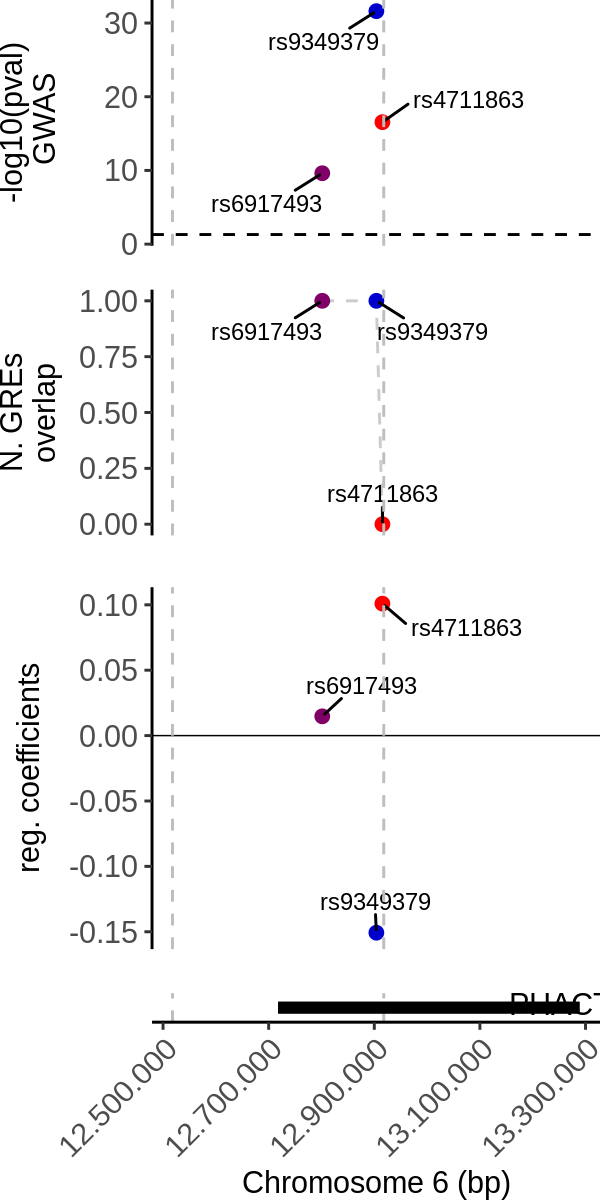

In [11]:
tissue <- 'Artery_Aorta'
gene_chosen <- 'PHACTR1'
prior_fold <- '/psycl/g/mpsziller/lucia/PriLer_PROJECT_GTEx/OUTPUT_SCRIPTS_v2_CAD_UKBB/'
prior_id_file <- sprintf('%s%s/priorName_CADgwas_withIndex.txt', prior_fold, tissue)
id_tissue <- which(tissues == tissue)

pl_tot <- plot_single_gene_reg(tissue = tissue, gene_chosen = gene_chosen, 
                               gwas_out = gwas_matched, ID_name = 'ID_CAD', prior_fold = prior_fold,
                               prior_id_file = prior_id_file, PriLer = T, tscore = tscore, n_show_rs = 4)
pl_tot$plot


ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_AA_%s.png', out_fold, gene_chosen), width = 3, height = 6, dpi = 200)
ggsave(plot = pl_tot$plot, filename = sprintf('%s/example_PriLer_AA_%s.pdf', out_fold, gene_chosen), width = 3, height = 6)
          
            

In [12]:
############################################
### annotate pathway significant results ###
############################################

common_i <- intersect(colnames(pathR), colnames(pathGO))
common_i <- intersect(colnames(pathWiki), common_i)
tmp1 <- pathR[, common_i]
tmp2 <- pathGO[, common_i]
tmp3 <- pathWiki[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tmp3$type_path <- 'WikiHuman'

tot_path <- rbind(tmp1, tmp2, tmp3)
# consider only significant ones:
tot_path <- tot_path[, !colnames(tot_path) %in% 'CAD_HARD_BHcorr_overall']
sign_path <- tot_path[tot_path[,15]<= 0.05,]

# add a column that indicates whether there is any gene from new loci
sign_path$gene_from_newloci <- NA

for(i in 1:nrow(sign_path)){
    
    id <- sapply(tscore_complete$external_gene_name, function(x) grepl(x, sign_path$genes_path[i])) & sign_path$tissue[i] == tscore_complete$tissue
    id <- id & !tscore_complete$best_GWAS_signBH
    if(any(id)){
        sign_path$gene_from_newloci[i] <- paste0(unique(tscore_complete$external_gene_name[id]), collapse = ',')
    }
}
paste('pathway from new loci:', sum(!is.na(sign_path$gene_from_newloci)), 'out of', nrow(sign_path))
table(sign_path$type_path)
                 
# add replication
pathR_repl <- fread(sprintf('%spath_Reactome_pval_Dx_covCorr_filt.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
pathGO_repl <- fread(sprintf('%spath_GO_pval_Dx_covCorr_filt.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
pathWiki_repl <- fread(sprintf('%spath_WikiPath2019Human_pval_Dx_covCorr_filt.txt', fold_rep), h=T, stringsAsFactors = F, data.table = F)
common_i <- intersect(colnames(pathR_repl), colnames(pathGO_repl))
common_i <- intersect(common_i, colnames(pathWiki_repl))
tmp1 <- pathR_repl[, common_i]
tmp2 <- pathGO_repl[, common_i]
tmp3 <- pathWiki_repl[, common_i]
tmp1$type_path <- 'Reactome'
tmp2$type_path <- 'GO'
tmp3$type_path <- 'WikiHuman'
tot_path_repl <- rbind(tmp1, tmp2, tmp3)

rep_df <- data.frame(CardioGram_beta = c(), CardioGram_se_beta =c(), CardioGram_z =c(),
                    CardioGram_pval =c(), CardioGram_pval_BHcorr =c(), CardioGram_Cochran_stat =c(),
                    CardioGram_Cochran_pval =c(), CardioGram_model = c(), stringsAsFactors = F)

for(i in 1:nrow(sign_path)){
        
        tmp <- tot_path_repl[tot_path_repl$path == sign_path$path[i] & tot_path_repl$tissue == sign_path$tissue[i],]
        new <- data.frame(CardioGram_beta = tmp$Dx_beta, CardioGram_se_beta =tmp$Dx_se_beta, 
                          CardioGram_z =tmp$Dx_z, CardioGram_pval =tmp$Dx_pval, 
                          CardioGram_pval_BHcorr =tmp$Dx_pval_BHcorr, 
                          CardioGram_Cochran_stat =tmp$Dx_Cochran_stat,
                          CardioGram_Cochran_pval =tmp$Dx_Cochran_pval, 
                          CardioGram_model = tmp$Dx_model, stringsAsFactors = F)
        
    rep_df <- rbind(rep_df,new)
}

path_complete <- cbind(sign_path, rep_df)
path_complete$replicated <- NA
path_complete$replicated <- sign(path_complete$CAD_HARD_z_t * path_complete$CardioGram_z)==1
# replicated pathways with genes from new loci
table(path_complete$replicated, !is.na(path_complete$gene_from_newloci))
# save
write.table(path_complete, file = sprintf('%sPathScores_CADHARD_annNewLoci_withReplication.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)


[1] "pathway from new loci: 53 out of 567"


       GO  Reactome WikiHuman 
      351       143        73 

       
        FALSE TRUE
  FALSE    77    4
  TRUE    437   49

In [13]:
summary(path_complete$CardioGram_pval)
table(path_complete$replicated, path_complete$type_path)
a=path_complete[path_complete$replicated & path_complete$CardioGram_pval <= 0.05,]
a[order(a$CardioGram_pval, decreasing = T)[1:10],]
table(path_complete$replicated & path_complete$CardioGram_pval <= 0.05, path_complete$type_path)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0154  0.1312  0.2776  0.5074  0.9914 

       
         GO Reactome WikiHuman
  FALSE  40       30        11
  TRUE  311      113        62

path                                                                
22145 dorsal/ventral pattern formation                                    
31718 neuroblast proliferation                                            
15978 insulin-like growth factor II binding                               
36068 Aryl Hydrocarbon Receptor WP2586                                    
4580  Gamma carboxylation, hypusine formation and arylsulfatase activation
21131 neuron projection morphogenesis                                     
34631 Aryl Hydrocarbon Receptor WP2586                                    
11157 response to retinoic acid                                           
26142 protein polyglutamylation                                           
24958 positive regulation of smooth muscle cell proliferation             
      ngenes_tscore ngenes_path mean_dev_geno sd_dev_geno mean_test_dev_geno
22145  5            49          0.11190464    0.037452495 0.027013889       
31718  3            17          0.04401294    0.038703477 0.037549818       
15978  2             3          0.24036576    0.279840709 0.128642857       
36068  2            46          0.01804954    0.007106775 0.008115077       
4580   8            39          0.13609217    0.135156665 0.073591133       
21131  2            46          0.04956484    0.020033263 0.016425326       
34631  3            46          0.03634516    0.007708305 0.026932443       
11157 12            54          0.07391348    0.070138816 0.031991778       
26142  2             7          0.07709266    0.019795513 0.013191087       
24958  3            46          0.12222077    0.122922047 0.030334470       
      sd_test_dev_geno mean_gene_corr sd_gene_corr CAD_HARD_beta ⋯
22145 0.0122976996      5.476713e-04  0.0019069149  0.0001969127 ⋯
31718 0.0424268318      6.735947e-05  0.0011389790 -0.0001532701 ⋯
15978 0.1793039132     -5.509303e-04            NA -0.0001209004 ⋯
36068 0.0080766457      4.817563e-04            NA -0.0001318360 ⋯
4580  0.0995646258      1.365313e-04  0.0017531283  0.0002278285 ⋯
21131 0.0224249998     -4.236206e-05            NA  0.0001272517 ⋯
34631 0.0087740158     -1.293790e-03  0.0018416039 -0.0001482022 ⋯
11157 0.0390355522      2.949210e-04  0.0014396488 -0.0003108655 ⋯
26142 0.0002999861      3.825025e-03            NA -0.0001216769 ⋯
24958 0.0106638012     -6.259086e-04  0.0008988735  0.0002117858 ⋯
      gene_from_newloci CardioGram_beta CardioGram_se_beta CardioGram_z
22145 NA                 0.05908278     0.03011985          1.961590   
31718 NA                -0.04615226     0.02331552         -1.979465   
15978 NA                -0.03809653     0.01907237         -1.997473   
36068 NA                -0.03808010     0.01904489         -1.999492   
4580  NA                 0.07622573     0.03812217          1.999512   
21131 NA                 0.03831494     0.01913323          2.002534   
34631 NA                -0.04677547     0.02332406         -2.005460   
11157 NA                -0.09320362     0.04646367         -2.005946   
26142 NA                -0.03815802     0.01895450         -2.013138   
24958 NA                 0.04707971     0.02332648          2.018295   
      CardioGram_pval CardioGram_pval_BHcorr CardioGram_Cochran_stat
22145 0.04981027      0.5232877               7.377512              
31718 0.04776362      0.5991300               5.098032              
15978 0.04577387      0.5265937              21.605275              
36068 0.04555518      0.6258885               9.783878              
4580  0.04555299      0.3544592               9.101205              
21131 0.04522734      0.4104782              11.156059              
34631 0.04491384      0.4949777               7.022783              
11157 0.04486196      0.5135199              10.025647              
26142 0.04410012      0.3928704               6.098461              
24958 0.04356058      0.4481459              12.457142              
      CardioGram_Cochran_pval CardioGram_model

       
         GO Reactome WikiHuman
  FALSE 202      112        47
  TRUE  149       31        26

[1] "It exists for T-score not concordant in sign results that reach nominal pvalue 0.05 in the replication: FALSE"
[1] "It exists for pathscore not concordant in sign results that reach nominal pvalue 0.05 in the replication: FALSE"


Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


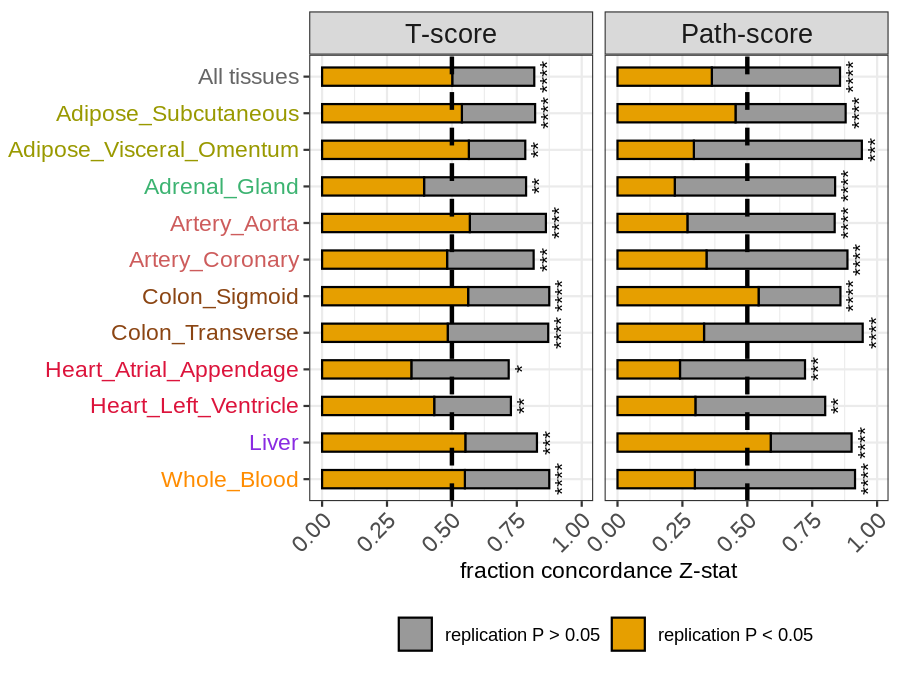

In [15]:
###############################################
### plot reproducibility on external cohort ###
###############################################
options(repr.plot.width = 6, repr.plot.height = 4.5, repr.plot.res = 150)

create_df_repr <- function(df_complete, pval_nom = 0.05, type_name){
    
    tissue_spec <- df_complete %>% group_by(tissue) %>% 
    summarise(n = length(replicated),
              n_sign = sum(replicated),
              frac_sign = sum(replicated)/length(replicated), 
              binomial_pval = binom.test(sum(replicated), length(replicated), p = 0.5, alternative = c("greater"))$p.value,
              frac_notsign = sum(!replicated)/length(replicated),
              frac_sign_nom = sum(replicated & CardioGram_pval <= pval_nom)/length(replicated),
              frac_sign_notnom = sum(replicated & CardioGram_pval > pval_nom)/length(replicated))

    df_summary <- df_complete %>% 
        summarise(tissue = 'All tissues', n = length(replicated),
              n_sign = sum(replicated),
              frac_sign = sum(replicated)/length(replicated), 
              binomial_pval = binom.test(sum(replicated), length(replicated), p = 0.5, alternative = c("greater"))$p.value,
              frac_notsign = sum(!replicated)/length(replicated),
              frac_sign_nom = sum(replicated & CardioGram_pval <= pval_nom)/length(replicated),
              frac_sign_notnom = sum(replicated & CardioGram_pval > pval_nom)/length(replicated)) %>% 
        bind_rows(tissue_spec) %>% mutate(type = type_name)
    
    df_pval <- df_summary %>% select(tissue, binomial_pval, frac_sign, type) %>% 
        mutate(pos = frac_sign + 0.05) %>% 
        mutate(sign_symbol = case_when(binomial_pval <=0.05 & binomial_pval>0.01 ~ "*", 
                                       binomial_pval <=0.01 & binomial_pval>0.001 ~ "**", 
                                       binomial_pval <=0.001 & binomial_pval>0.0001 ~ "***",
                                       binomial_pval <=0.0001 ~ "****"))
    
    tmp1 <- df_summary %>% select(tissue, n,  n_sign, frac_sign, frac_sign_notnom, type) %>% 
        mutate(type_rep = sprintf('replication P > %.2f', pval_nom)) %>% rename( frac = frac_sign_notnom)
    tmp2 <- df_summary %>% select(tissue, n , n_sign, frac_sign, frac_sign_nom, type) %>% 
        mutate(type_rep = sprintf('replication P < %.2f', pval_nom)) %>% rename(frac = frac_sign_nom)
    
    output <- bind_rows(tmp1, tmp2)
    output$type_rep <- factor(output$type_rep, 
                              levels = c(sprintf('replication P > %.2f', pval_nom),
                                         sprintf('replication P < %.2f', pval_nom)))
    output$tissue <- factor(output$tissue, levels = rev(df_summary$tissue))
    df_pval$tissue <- factor(df_pval$tissue, levels = rev(df_summary$tissue))

    return(list(pval = df_pval, frac = output))

}

## tscore: 
val <- any(!tscore_complete$replicated & tscore_complete$CardioGram_pval <= 0.05)
print(paste('It exists for T-score not concordant in sign results that reach nominal pvalue 0.05 in the replication:', val))

## path
val <- any(!path_complete$replicated & path_complete$CardioGram_pval <= 0.05)
print(paste('It exists for pathscore not concordant in sign results that reach nominal pvalue 0.05 in the replication:', val))

df_t <- create_df_repr(df_complete = tscore_complete, type_name = 'T-score')
df_p <- create_df_repr(df_complete = path_complete, type_name = 'Path-score')

df_frac <- rbind(df_t$frac, df_p$frac) 
df_pval <- rbind(df_t$pval, df_p$pval) 
df_frac$type <- factor(df_frac$type, levels = c('T-score','Path-score'))
df_pval$type <- factor(df_pval$type, levels = c('T-score','Path-score'))

color_tissues_CAD <- color_tissues$color[match(tissues, color_tissues$tissues)]
color_tissues_CAD <- c('#666666', color_tissues_CAD)


pl_bar <- ggplot(data = df_frac, mapping = aes(x = tissue, y = frac, fill = type_rep))+
  geom_bar(stat = 'identity', color = 'black', alpha = 1, width = 0.5)+
  geom_hline(yintercept = 0.5, linetype = 'dashed', size = 1)+
  geom_text(data = df_pval, aes(x = tissue, y = pos, label = sign_symbol), size = 3.5, 
            angle = 90, inherit.aes = FALSE)+
  facet_wrap(.~type, nrow = 1)+
  theme_bw()+
  theme(legend.position = 'bottom', legend.title = element_blank(), 
        axis.text.y = element_text(colour = rev(color_tissues_CAD), size = 11), 
        axis.text.x = element_text(angle = 45, hjust = 1, size = 11),
        axis.title.y = element_blank(), strip.text.x = element_text(size = 13))+
  scale_fill_manual(values = c('#999999','#E69F00'))+
  ylab('fraction concordance Z-stat')+
  coord_flip()

pl_bar

write.table(file  = sprintf('%s/signConcordance_discoveryUKBB_replicationCardioGram.txt', out_fold), 
            x = df_frac, 
            quote = F, sep = "\t", 
            col.names = T, 
            row.names = F)
ggsave(plot = pl_bar, filename = sprintf('%s/signConcordance_discoveryUKBB_replicationCardioGram.png', out_fold), width = 6, height = 4.5, dpi = 200)
ggsave(plot = pl_bar, filename = sprintf('%s/signConcordance_discoveryUKBB_replicationCardioGram.pdf', out_fold), width = 6, height = 4.5)



In [17]:
str(tscore_complete)

'data.frame':	383 obs. of  35 variables:
 $ type                   : chr  "heritable" "heritable" "heritable" "heritable" ...
 $ chrom                  : chr  "chr1" "chr1" "chr1" "chr2" ...
 $ TSS_start              : int  109633479 222834853 234509202 85788669 203776937 203879602 46735193 134205557 31239906 31324424 ...
 $ start_position         : int  109630593 222832209 234509202 85771846 203776937 203879602 46710487 134196548 31236526 31324424 ...
 $ end_position           : int  109633480 222834854 234519795 85788670 203851786 204091101 46735194 134205558 31239907 31325414 ...
 $ ensembl_gene_id        : chr  "ENSG00000273382" "ENSG00000272750" "ENSG00000168275" "ENSG00000115486" ...
 $ external_gene_name     : chr  "RP5-1065J22.8" "RP11-378J18.8" "COA6" "GGCX" ...
 $ dev_geno               : num  0.1104 0.0563 0.1255 0.0421 0.0267 ...
 $ test_dev_geno          : num  0.0584 0.0322 0.0992 0.0169 0.0174 ...
 $ CAD_HARD_beta          : num  -0.000115 -0.000191 0.000102 0.00017 -0.0

### Reproducibility: 
- consider significant results for UKBB
- fraction of concordance based on the same sign of Z-statisitc
- Additionally, shown the fraction of same sign results that have a nominal p-value <= 0.05
- Note that no nominal result in the replication cohorts have an opposite sign with the discovery cohort.
- Genes: from a all tissue point of view, 0.82 reproduced among which 0.5 reach nominal significance out of 383 significant genes, generally fraction > 0.7 and additional nominal > 0.34
- Pathways: out of 567 pathways, 0.85 have same sign and 0.36 are significant at the nominal level. Lower results for HAA (same as genes) with 0.72 same sign (39/54) and 0.24 at nominal p-value.


       GO  Reactome WikiHuman 
      351       143        73 

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


n 
1 38

n
1 4

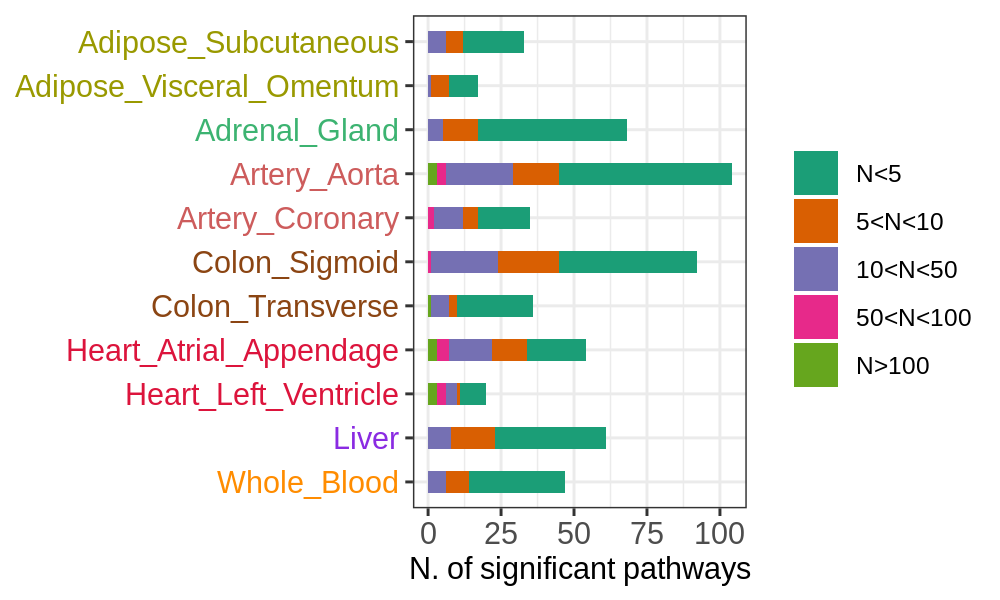

In [12]:
###############################
### Pathway general results ###
###############################

options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 200)

df_path <- path_complete
df_path <- df_path %>% 
    mutate(ngenes_binned = case_when(ngenes_tscore <5 ~ "N<5", 
                                     ngenes_tscore <10 & ngenes_tscore>=5 ~ "5<N<10", 
                                     ngenes_tscore <50 & ngenes_tscore>=10 ~ "10<N<50", 
                                     ngenes_tscore <100 & ngenes_tscore>=50 ~ "50<N<100", 
                                     ngenes_tscore>=100 ~ "N>100"), .after = ngenes_tscore)
df_path$ngenes_binned <- factor(df_path$ngenes_binned, levels = c("N<5","5<N<10", "10<N<50", "50<N<100", "N>100"))

table(df_path$type_path)

df_table <- as.data.frame(table(df_path$tissue, df_path$ngenes_binned))
df_table$Var1 <- factor(df_table$Var1, levels = rev(tissues)) 
color_tissues_CAD <- color_tissues$color[match(tissues, color_tissues$tissues)]


pl_bar <- ggplot(data = df_table, mapping = aes(x = Var1, y = Freq, fill = Var2))+
  geom_bar(stat = 'identity', alpha = 1, width = 0.5)+
  theme_bw()+
  theme(legend.position = 'right', legend.title = element_blank(), 
        axis.text.y = element_text(colour = rev(color_tissues_CAD), size = 11), 
        axis.text.x = element_text(angle = 0, size = 11),
        axis.title.y = element_blank(), strip.text.x = element_text(size = 13))+
  scale_fill_brewer(palette = 'Dark2')+
  ylab('N. of significant pathways')+
  coord_flip()

pl_bar

ggsave(plot = pl_bar, filename = sprintf('%s/n_significant_path_pertissue.png', out_fold), width = 5, height = 3, dpi = 200)
ggsave(plot = pl_bar, filename = sprintf('%s/n_significant_path_pertissue.pdf', out_fold), width = 5, height = 3)

# how many paths with 'CDKN2B' in CS?
df_path %>% filter(tissue == 'Colon_Sigmoid') %>% summarise(n = sum(grepl('CDKN2B', genes_path)))
df_path %>% filter(tissue == 'Artery_Aorta') %>% summarise(n = sum(grepl('PHACTR1', genes_path)))


### Pathwy associations: 
- same pathway removed but not redundant
- correction via FDR, for each tissue and database separately
- In total, GO = 351, Reactom = 143, WikiHuman = 73
- Tissues with the majority of associations are Colon Sigmoid and Artery Aorta. AA is the tissue with the majority of genes associated (see supp fig.) and not for a single strong gene (PATCHR1 only in 4 pathways) and CS include the most significant association CDKN2B. Indeed 38 out 92 significant pathways include CDKN2B.


                   genes P < pathway P pathway P < genes P & genes FDR < 0.05 
                                   312                                     79 
pathway P < genes P & genes FDR > 0.05 
                                   176 


                   genes P < pathway P pathway P < genes P & genes FDR < 0.05 
                             0.5502646                              0.1393298 
pathway P < genes P & genes FDR > 0.05 
                             0.3104056 

[1] 567

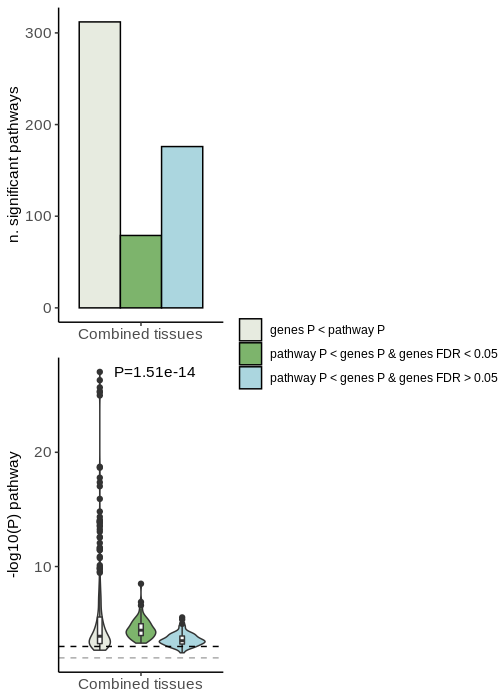

In [13]:
#######################################################################
### number of significant pathways that have better sign than genes ###
#######################################################################
# all tissues combined
options(repr.plot.width = 5, repr.plot.height = 7, repr.plot.res = 100)
pl_npath <- plot_classPath(path_sign = path_complete, gene_tot = tscore, 
                           id_pval = 13, id_pval_gene = 8, pval_FDR = pval_FDR, 
                           fold = out_fold, pheno = pheno, height_pl = 7, width_pl = 5)

pl_npath$pl
table(pl_npath$df$class)
table(pl_npath$df$class)/nrow(pl_npath$df)
nrow(pl_npath$df)
#summary(pl_npath$df$log10p[pl_npath$df$class == 'genes P < pathway P'])
#summary(pl_npath$df$log10p[pl_npath$df$class == 'pathway P < genes P\ngenes FDR < 0.05'])

path_complete_ann <- path_complete
path_complete_ann$class_pathway <- NA
pl_npath$df$class <- as.character(pl_npath$df$class)
for(i in 1:nrow(path_complete_ann)){
  id <- pl_npath$df$path == path_complete_ann$path[i] & pl_npath$df$tissue == path_complete_ann$tissue[i] & pl_npath$df$type_path == path_complete_ann$type_path[i] 
  path_complete_ann$class_pathway[i] <- pl_npath$df$class[id]
}
# save
write.table(path_complete_ann, file = sprintf('%sPathScores_CADHARD_annNewLoci_withReplication_annClass.txt',out_fold), 
           col.names = T, row.names= F, sep = '\t', quote = F)


45% (176 + 79) of pathways are more significant than any gene in it. Among which 176 (31% of the total) do not include any significant genes! 

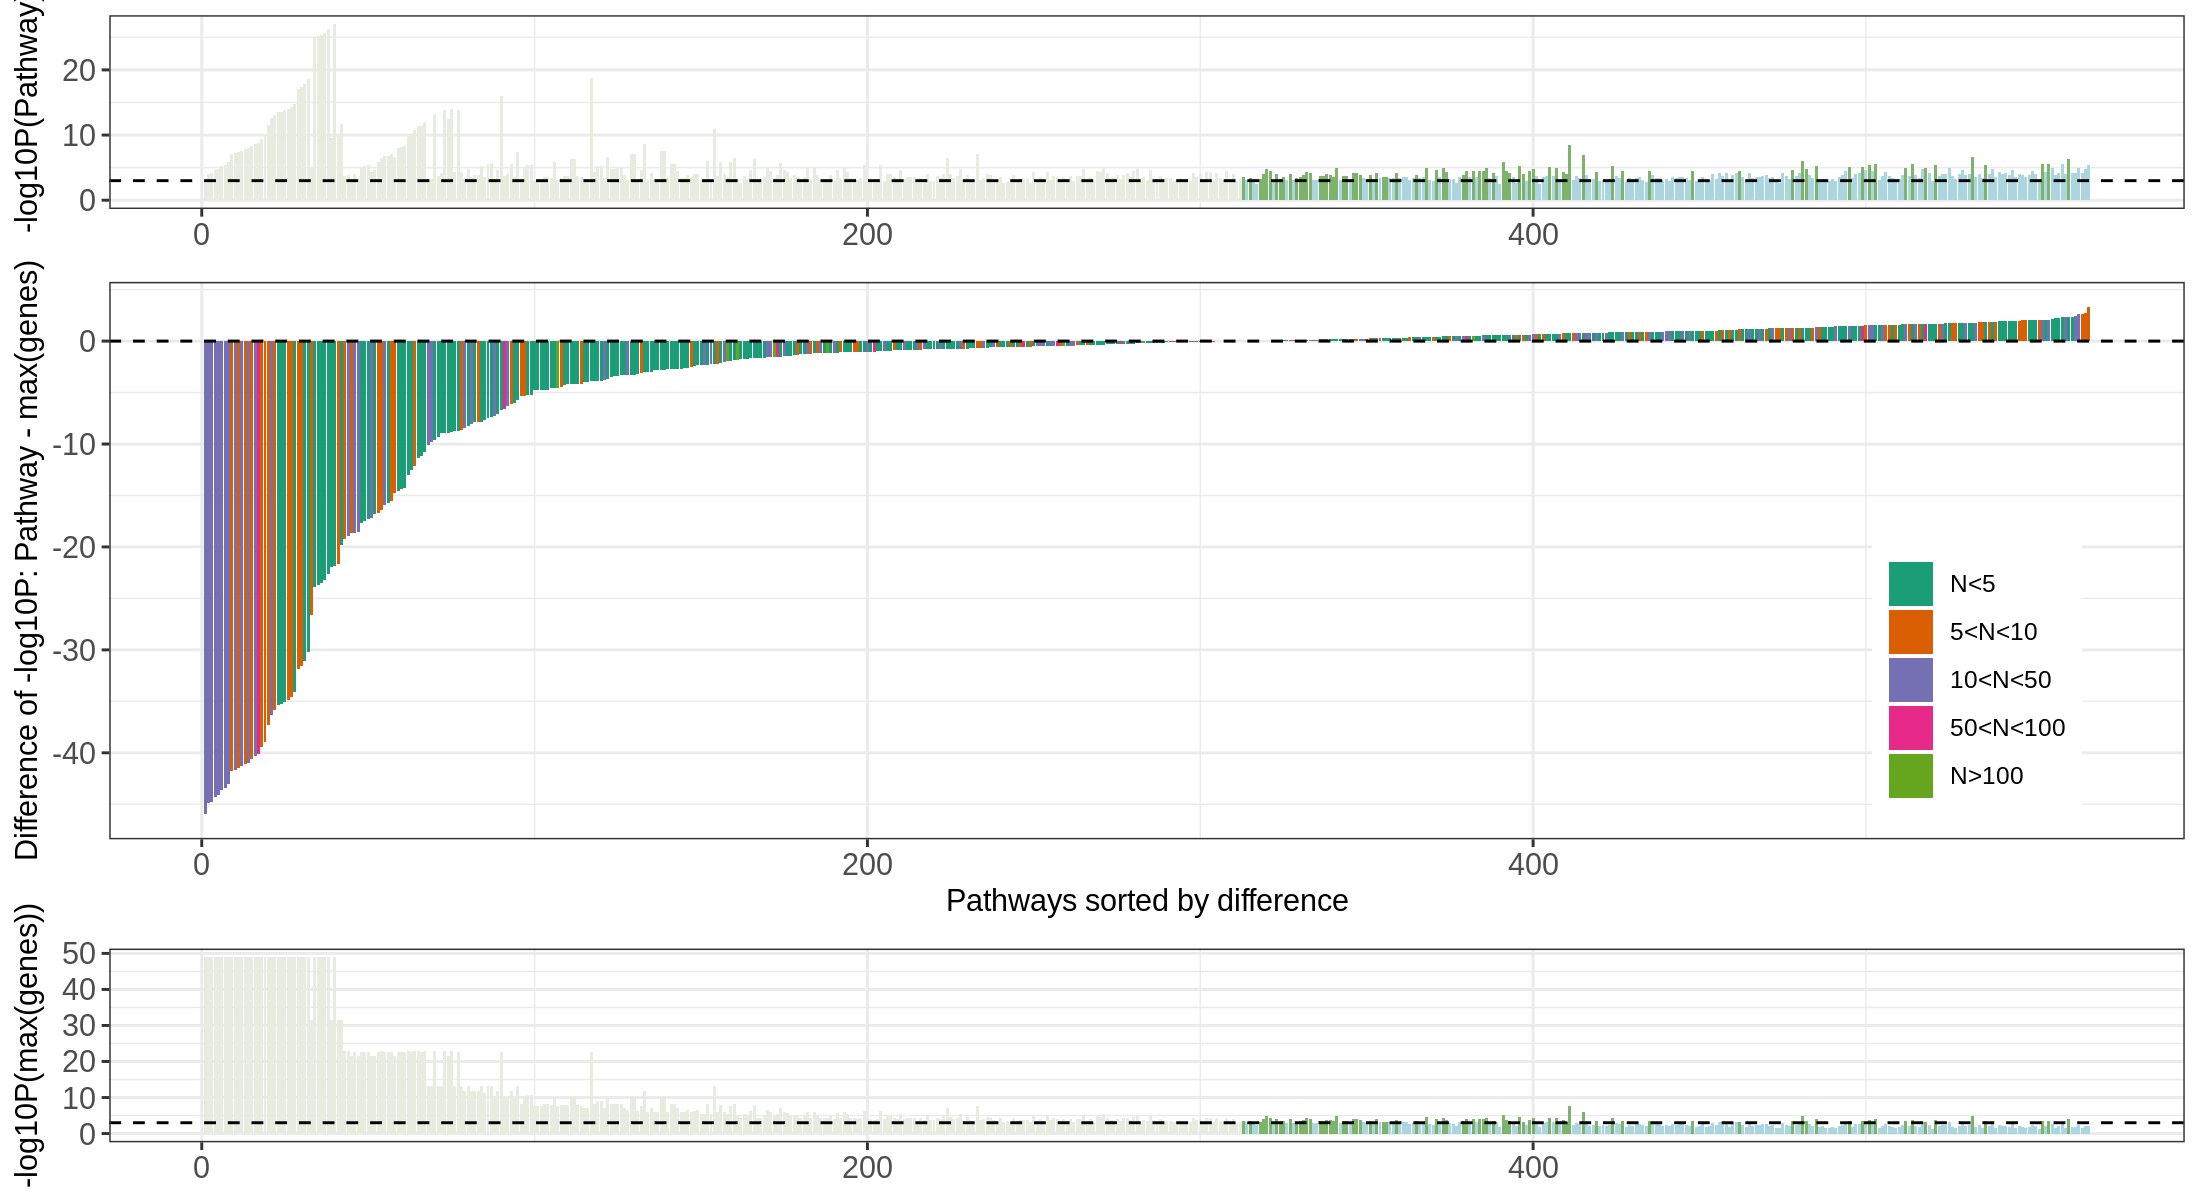

In [14]:
############################
### pathway prioritazion ###
############################

options(repr.plot.width = 11, repr.plot.height = 6, repr.plot.res = 200)

df <- pl_npath$df %>% mutate(diff = log10p - max_gene_log10p) %>% arrange(diff, max_gene_log10p, log10p) %>%
    mutate(index = 1:nrow(path_complete)) %>% 
    mutate(ngenes_binned = case_when(ngenes_tscore <5 ~ "N<5", 
                                     ngenes_tscore <10 & ngenes_tscore>=5 ~ "5<N<10", 
                                     ngenes_tscore <50 & ngenes_tscore>=10 ~ "10<N<50", 
                                     ngenes_tscore <100 & ngenes_tscore>=50 ~ "50<N<100", 
                                     ngenes_tscore>=100 ~ "N>100"))
df$ngenes_binned <- factor(df$ngenes_binned, levels = c("N<5","5<N<10", "10<N<50", "50<N<100", "N>100"))

pl <- ggplot(data = df, mapping = aes(x = index, y = diff, fill = ngenes_binned))+
  geom_bar(stat = 'identity')+
  geom_hline(yintercept = 0, linetype = 'dashed', size = 0.5)+
  theme_bw()+
  theme(legend.position = c(0.9,0.3), legend.title = element_blank(), 
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
  ylab('Difference of -log10P: Pathway - max(genes)') + 
  xlab('Pathways sorted by difference')+
  scale_fill_brewer(palette = 'Dark2')

pl_log10 <- ggplot(data = df, mapping = aes(x = index, y = log10p, fill = class))+
   geom_bar(stat = 'identity')+
  theme_bw()+
  geom_hline(yintercept = -log10(0.001), linetype = 'dashed', size = 0.5)+
  theme(legend.position = 'none', legend.title = element_blank(), 
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
  ylab('-log10P(Pathway)') + scale_fill_manual(values = c('#E7EBE0FF','#7DB46CFF', '#ABD6DFFF'))

pl_maxgenelog10 <- ggplot(data = df, mapping = aes(x = index, y = max_gene_log10p, fill = class))+
  geom_bar(stat = 'identity')+
  theme_bw()+
  geom_hline(yintercept = -log10(0.001), linetype = 'dashed', size = 0.5)+
  theme(legend.position = 'none', legend.title = element_blank(), 
        axis.title.x = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
  ylab('-log10P(max(genes))') + scale_fill_manual(values = c('#E7EBE0FF','#7DB46CFF', '#ABD6DFFF'))


pl_tot <- ggarrange(plotlist = list(pl_log10, pl, pl_maxgenelog10), align = 'v',  ncol = 1, heights = c(0.4, 1, 0.4))
pl_tot
ggsave(plot = pl_tot, filename = sprintf('%s/diff_path_tscores_pvalue.png', out_fold), width = 11, height = 6, dpi = 200)
ggsave(plot = pl_tot, filename = sprintf('%s/diff_path_tscores_pvalue.pdf', out_fold), width = 11, height = 6)


- Indeed, those less significant than a gene in it show a big gap between pathway and gene significance
- mostly coming from CDKN2B gene and SORT1 locus genes. Note that the big gap comphrened pathways with a lot of genes in it and it decrease as the number of genes decrease. 
- the idea is that a single very significant gene "disrupt" and entire pathway. On the other hand small effects concordant in sign aggregate and lead to a cooperative disruption. 
- What are these "novel" pathways? Consider only those having genes > 5 or >=3 but coverage >=10%, < 200, total genes < 200, and P <= 0.0001

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”



pathway P < genes P & genes FDR < 0.05 pathway P < genes P & genes FDR > 0.05 
                                    24                                     21 

type_path tissue                  
9  GO        Colon_Transverse        
11 GO        Adrenal_Gland           
13 GO        Adipose_Visceral_Omentum
20 WikiHuman Artery_Aorta            
21 GO        Heart_Atrial_Appendage  
23 GO        Liver                   
30 Reactome  Artery_Coronary         
31 GO        Artery_Coronary         
34 GO        Heart_Atrial_Appendage  
39 GO        Adipose_Visceral_Omentum
40 GO        Adrenal_Gland           
   path                                                          ngenes_path
9  receptor recycling                                             8         
11 positive regulation of phosphatidylinositol 3-kinase activity 25         
13 iron-sulfur cluster assembly                                  13         
20 Neovascularisation processes WP4331                           21         
21 centriole                                                     72         
23 glutathione peroxidase activity                               17         
30 RNA Polymerase I Promoter Clearance                           79         
31 regulation of innate immune response                          13         
34 regulation of protein kinase activity                         19         
39 endosome organization                                         23         
40 acrosome reaction                                             15         
   ngenes_tscore log10p   zstat     impr no_sign_genes mean_gene_log10p ⋯
9   3            5.348327  4.587583 1    FALSE         2.208030         ⋯
11  3            5.115770  4.474473 1    FALSE         2.259845         ⋯
13  3            4.917705  4.376024 1    FALSE         2.264509         ⋯
20  3            4.464576 -4.142793 1     TRUE         1.883975         ⋯
21 12            4.458263 -4.139459 1    FALSE         1.000518         ⋯
23  5            4.423502 -4.121058 1    FALSE         1.394496         ⋯
30  5            4.249500 -4.027809 1     TRUE         1.164271         ⋯
31  3            4.248984 -4.027530 1     TRUE         1.701778         ⋯
34  3            4.178960 -3.989446 1     TRUE         1.906426         ⋯
39  3            4.116499  3.955197 1     TRUE         1.834973         ⋯
40  4            4.110035 -3.951637 1     TRUE         1.600421         ⋯
   class_effect tissue_tot       diff      index ngenes_binned logpval 
9  NA           Combined tissues 1.7012440 521   N<5           5.348327
11 NA           Combined tissues 0.6754581 405   N<5           5.115770
13 NA           Combined tissues 0.4153598 368   N<5           4.917705
20 NA           Combined tissues 1.4509825 494   N<5           4.464576
21 NA           Combined tissues 0.9120753 435   10<N<50       4.458263
23 NA           Combined tissues 1.1670742 462   5<N<10        4.423502
30 NA           Combined tissues 2.6394023 565   5<N<10        4.249500
31 NA           Combined tissues 2.3907137 562   N<5           4.248984
34 NA           Combined tissues 1.1110444 461   N<5           4.178960
39 NA           Combined tissues 1.0309189 456   N<5           4.116499
40 NA           Combined tissues 1.2542612 475   N<5           4.110035
   P            improvement_sign
9  4.484079e-06 FALSE           
11 7.660014e-06 FALSE           
13 1.208636e-05 FALSE           
20 3.431022e-05  TRUE           
21 3.481261e-05 FALSE           
23 3.771363e-05 FALSE           
30 5.629897e-05  TRUE           
31 5.636584e-05  TRUE           
34 6.622782e-05  TRUE           
39 7.647171e-05  TRUE           
40 7.761843e-05  TRUE           
   name                                                                       
9  receptor recycling_Colon_Transverse                                        
11 positive regulation of phosphatidylinositol 3-kinase activity_Adrenal_Gland
13 iron-sulfur cluster assembly_Adipose_Visceral_Omentum                      
20 Neovascularisation processes WP4331_Artery_Aorta                           
21 centriole_Heart_Atrial_Appendage                                           
2

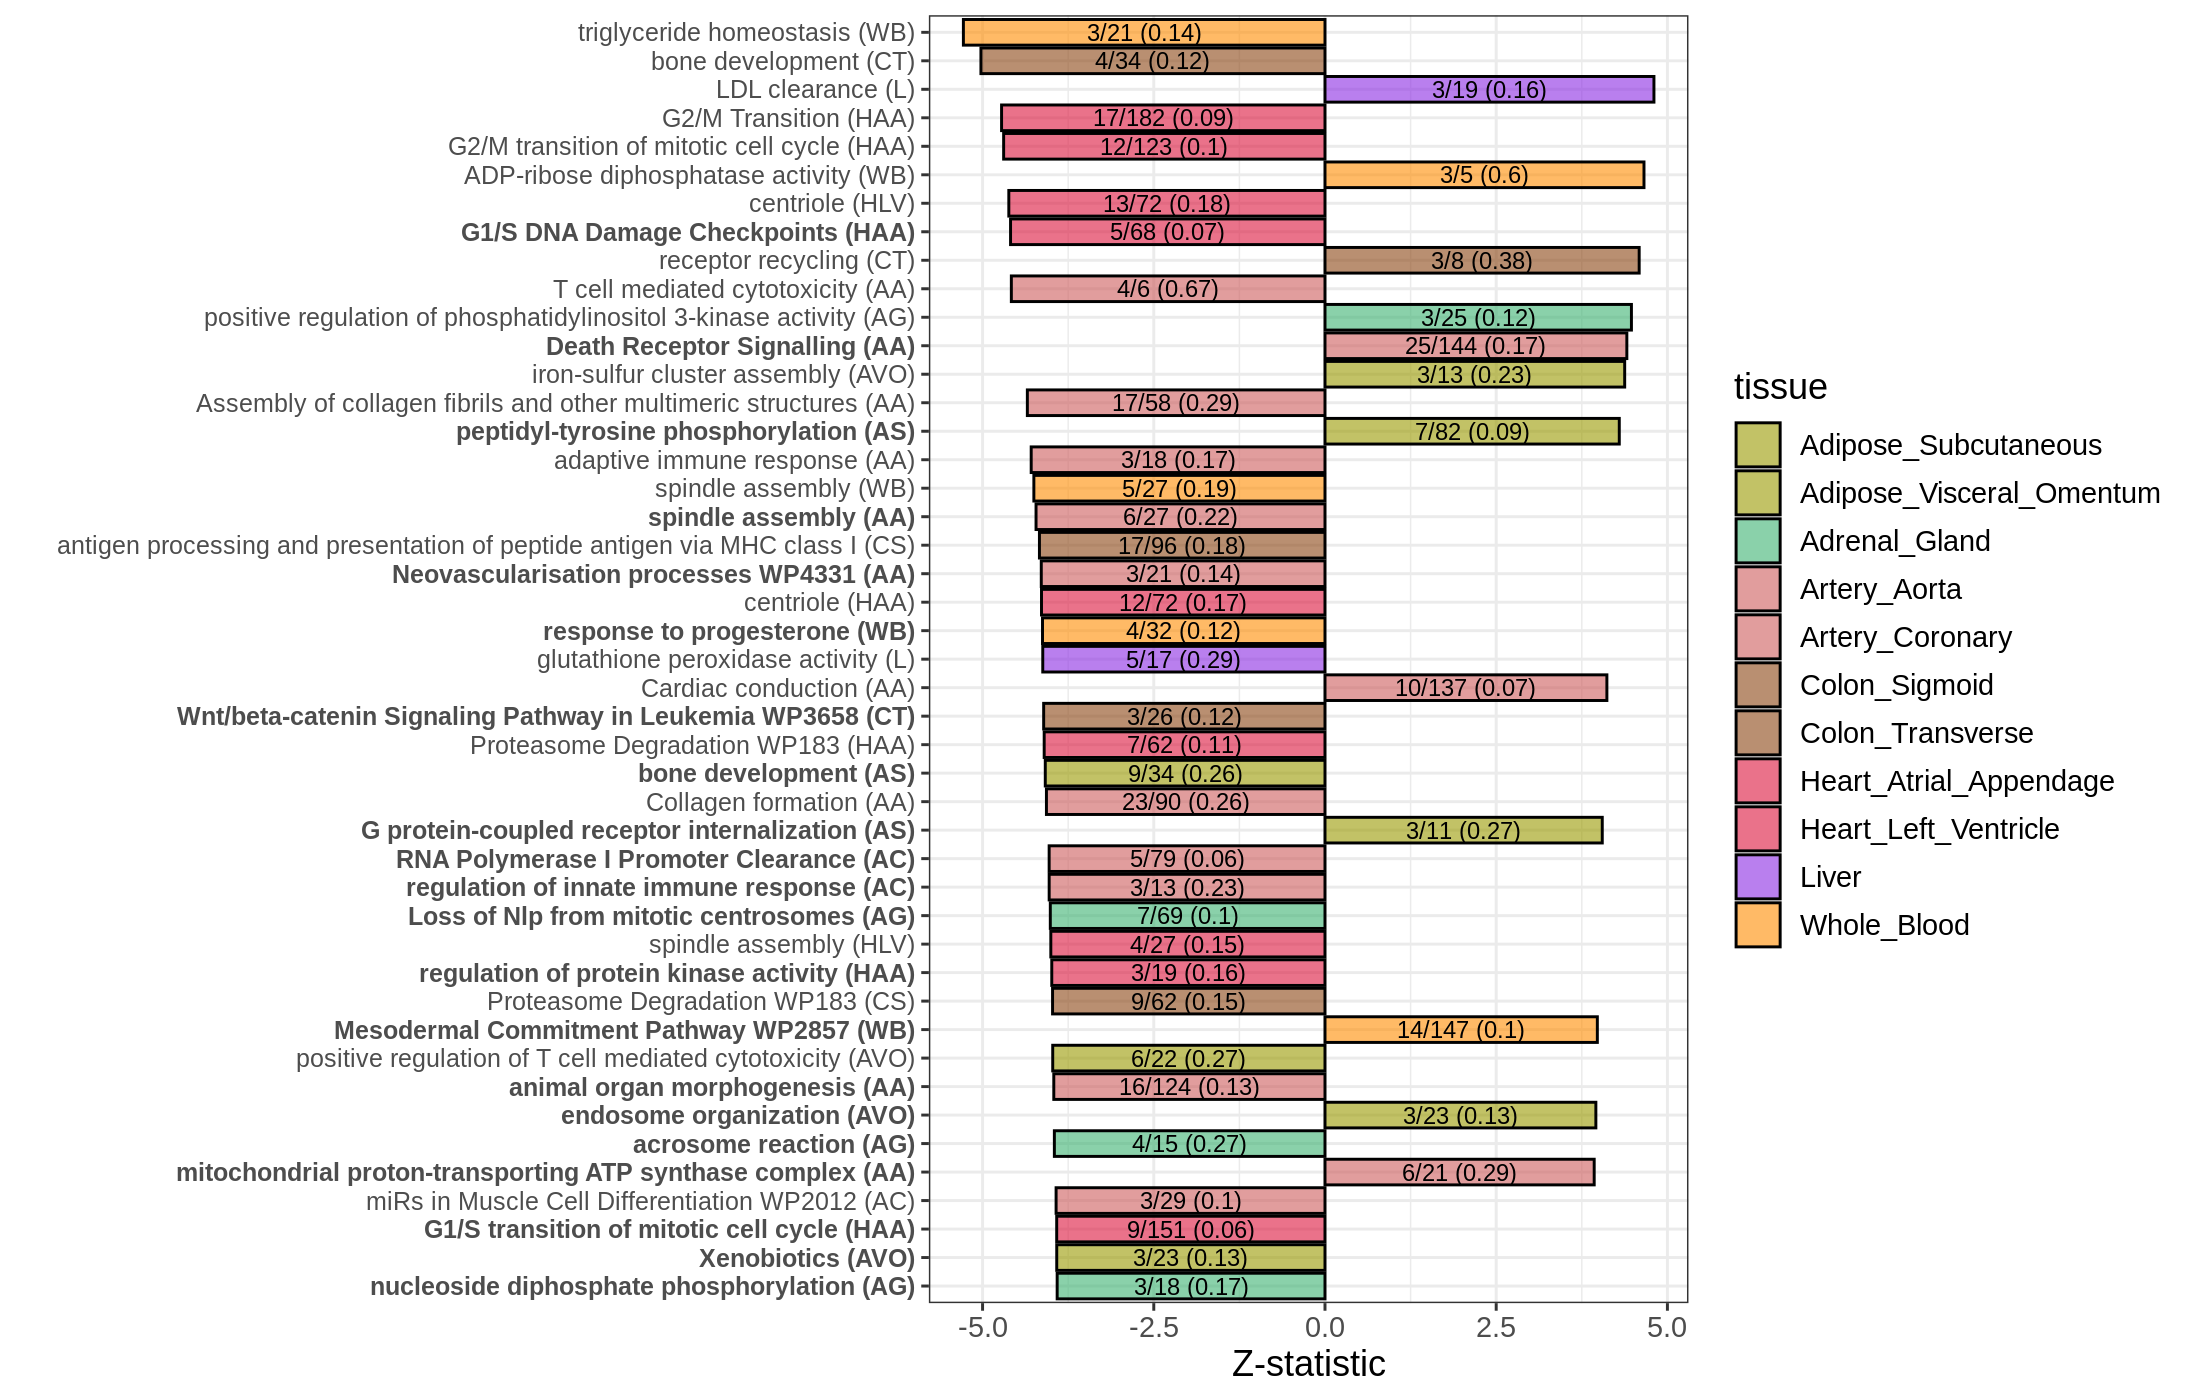

In [15]:
options(repr.plot.width = 11, repr.plot.height = 7, repr.plot.res = 200)

path_novel <- df %>% filter(ngenes_tscore <= 200 & ngenes_path <=200, 
                            ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3),
                            diff > 0, log10p > 4) %>% 
    arrange(desc(log10p))

path_novel$logpval <-  path_novel$log10p
path_novel$P <-  1/10^(path_novel$log10p)
path_novel$improvement_sign <- F
path_novel$improvement_sign[path_novel$class == 'pathway P < genes P & genes FDR > 0.05'] <- T

# remove repetition on CS
path_novel <- path_novel %>% filter(!(tissue == 'Colon_Sigmoid' & path %in% 
                                      c('antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-dependent', 
                                       'antigen processing and presentation of exogenous peptide antigen via MHC class I, TAP-independent',
                                       'antigen processing and presentation of exogenous peptide antigen via MHC class I')))

# save
pl <- plot_best_path(best_res = path_novel, color_tissues = color_tissues, type_mat = 'path', 
               outFold = sprintf('%snovel_', out_fold), type_dat = type_dat, tissues = tissues, height_plot = 7, 
                     width_plot = 10, id_pval = ncol(path_novel) -1)
# plot
pl$pl_zstat
table(path_novel$class)

path_novel$name <- paste(path_novel$path, path_novel$tissue, sep = '_')
tmp <- path_complete %>% mutate(name = paste(path, tissue, sep = '_'))
tmp <- tmp[match(path_novel$name, tmp$name),]
path_novel$replicated <- tmp$replicated & tmp$CardioGram_pval <= 0.05
path_novel[path_novel$replicated, ]



- With this filtering criteria we get 45 "novel" pathways. Would be they detected from SNP data?
- 11 out of 45 are also significant at the nominal level in the replication cohort

- For the pathways that are less significant than gene, we hypothesisze that a single gene disrupt the entire pathway but the other genes are not so "collaborative". We show the significant pathways in term of same selection as for the "novel" but group by the most significant gene and chose as exemplar pathway the one with highest coverage.

[1] 63 21

[1] 23

Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”
Warning message:
“Vectorized input to `element_text()` is not officially supported.
Results may be unexpected or may change in future versions of ggplot2.”


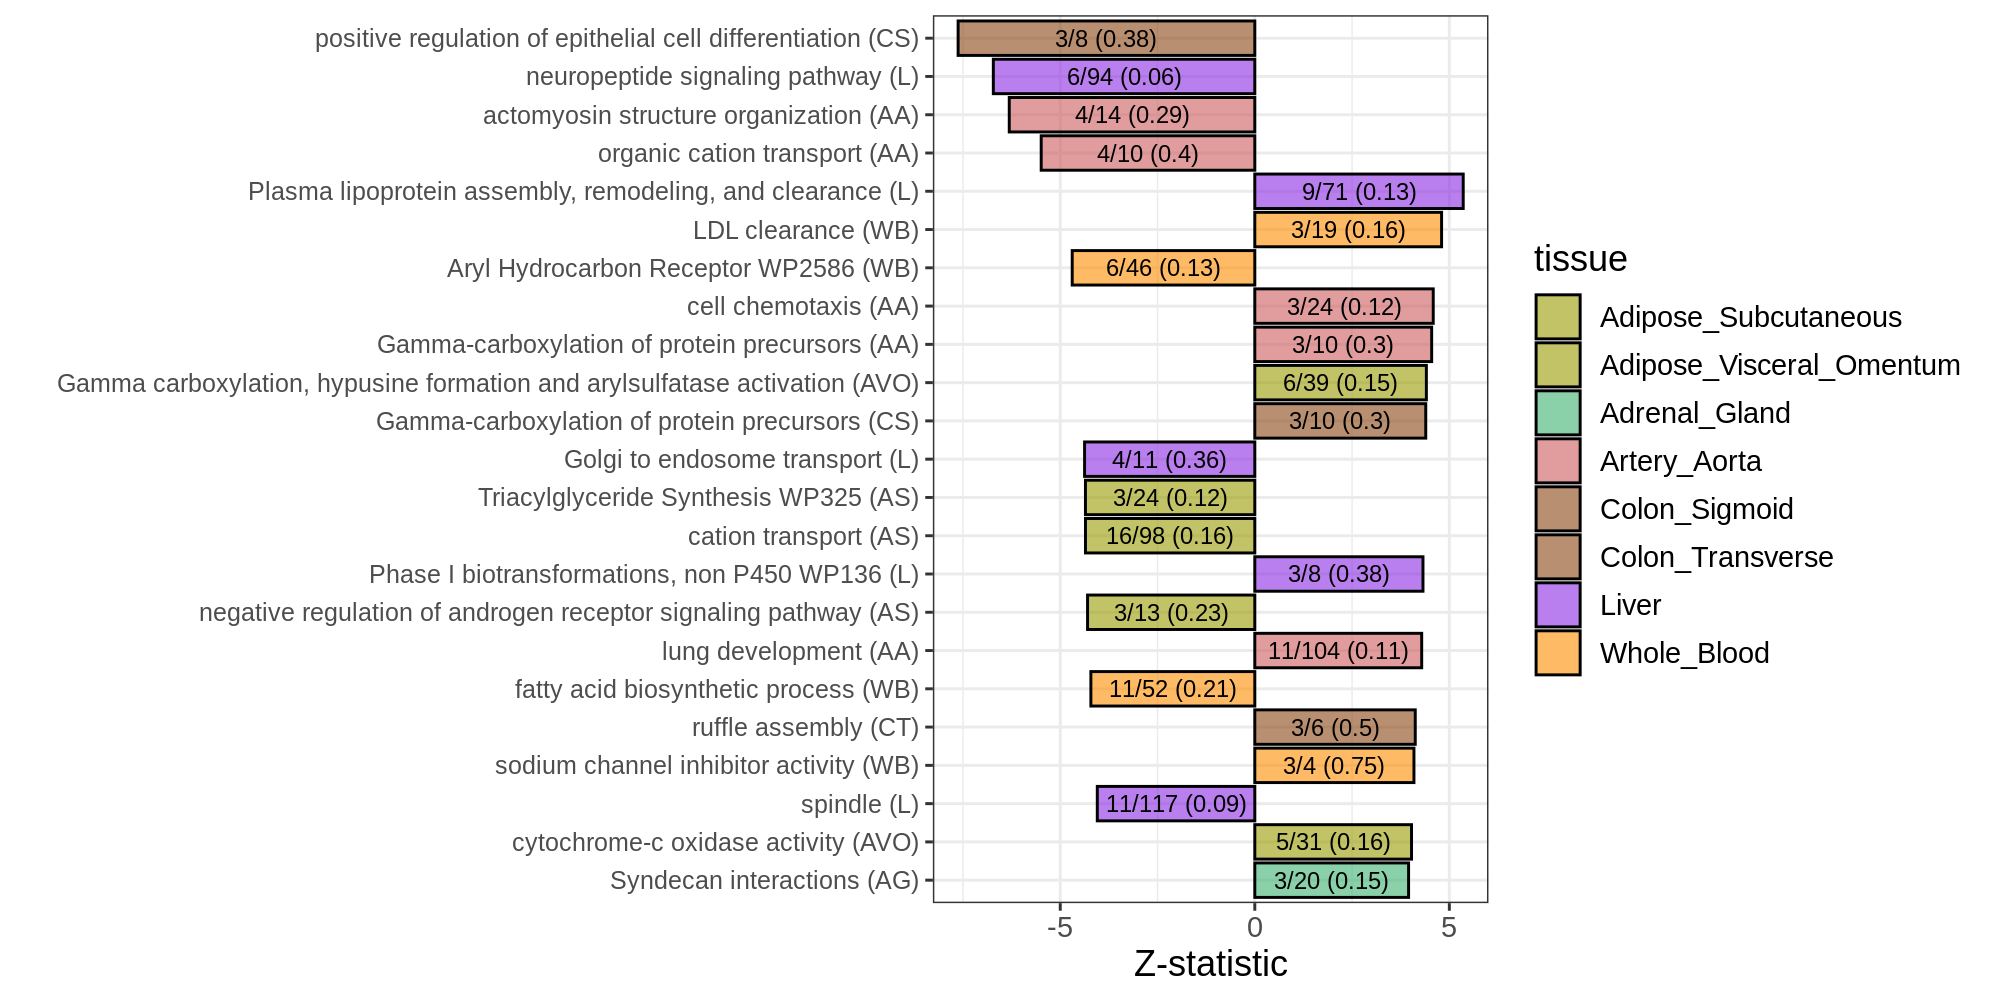

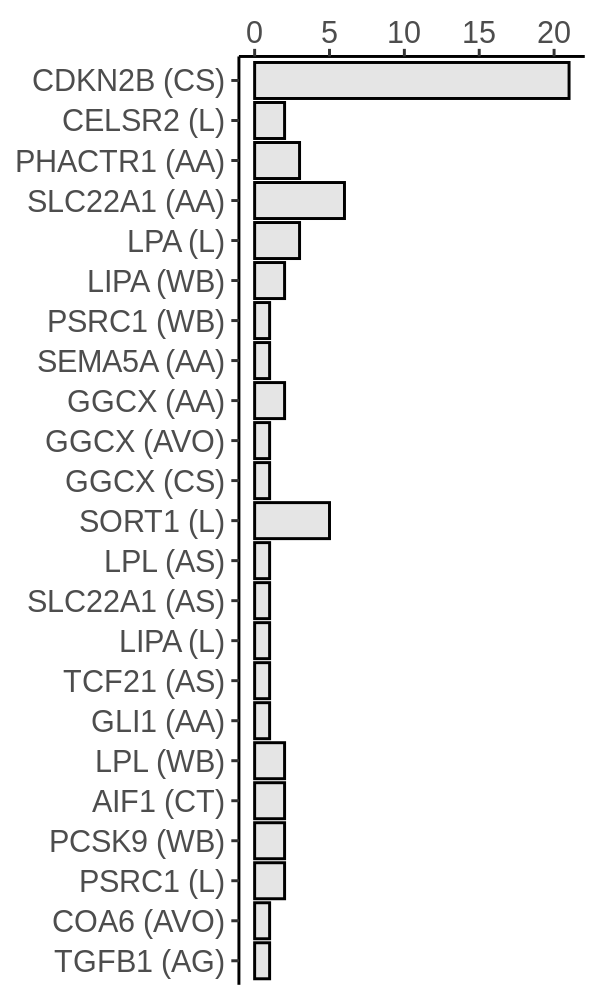

In [16]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)

path_known <- df %>% filter(ngenes_tscore <= 200 & ngenes_path <=200, 
                            ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3),
                            diff < 0, log10p > 4) %>% 
    arrange(desc(log10p))

dim(path_known)

path_known$logpval <-  path_known$log10p
path_known$best_gene <- NA
path_known$best_gene_tissue <- NA
path_known$name <- paste(path_known$path, path_known$tissue, sep = '_')

# strongest gene association for each pathway:
for(i in 1:nrow(path_known)){

    tmp <- path_complete %>% filter(path_complete$type_path == path_known$type_path[i], 
                             path_complete$tissue == path_known$tissue[i], 
                             path_complete$path == path_known$path[i])
    
    genes <- strsplit(tmp$genes_path, split = '[,]')[[1]]

    gene_info <- tscore %>%  filter(tissue == path_known$tissue[i], external_gene_name %in% genes)
    path_known$best_gene[i] <- gene_info$external_gene_name[which.min(gene_info$CAD_HARD_pval)] 
    
    tmp_tissue <- paste0(sapply(strsplit(path_known$tissue[i], split = '[_]')[[1]], 
                                function(y) substr(y, start = 1, stop = 1)), collapse = '')

    path_known$best_gene_tissue[i] <- paste0(path_known$best_gene[i], ' (',tmp_tissue,')')
    path_known$best_gene_tissue_c[i] <- paste0(path_known$best_gene[i], ' (',path_known$tissue[i],')')
    
}
length(table(path_known$best_gene_tissue))
names_t <- unique(path_known$best_gene_tissue_c)
genes <- sapply(names_t, function(x) strsplit(x, split = '[ (]')[[1]][1])
names_t <- sapply(names_t, function(x) strsplit(x, split = '[(]')[[1]][2])
names_t <- sapply(names_t, function(x) strsplit(x, split = '[)]')[[1]][1])
                  
# how many non significant pathways have those genes?
df_best_gene <- data.frame(id = unique(path_known$best_gene_tissue),
                           freq = sapply(unique(path_known$best_gene_tissue), 
                                         function(x) sum(path_known$best_gene_tissue == x)), 
                           tissue = unname(names_t), gene = genes, 
                           n_notsign = NA, examplar = NA, coverage = NA)
                  
for(i in 1:nrow(df_best_gene)){
    tmp <- tot_path %>% filter(CAD_HARD_pval > 0.0001 &  CAD_HARD_BHcorr >=0.05, 
                                    ngenes_tscore <= 200 & ngenes_path <=200, 
                                    ngenes_tscore >= 5 | (ngenes_tscore/ngenes_path >= 0.1 & ngenes_tscore >= 3), 
                                    grepl(df_best_gene$gene[i], genes_path) , tissue == df_best_gene$tissue[i])
    
    df_best_gene$n_notsign[i] <- nrow(tmp)
    best_res <- path_known[path_known$best_gene_tissue == df_best_gene$id[i],]
    id <- which.max(best_res$ngenes_tscore/best_res$ngenes_path)
    df_best_gene$examplar[i] <- best_res$path[id]
    df_best_gene$coverage[i] <- best_res$ngenes_tscore[id]/best_res$ngenes_path[id]
    df_best_gene$zstat[i] <- best_res$zstat[id]
    
}
df_best_gene$name_tot <- paste(df_best_gene$examplar, df_best_gene$tissue, sep = '_')

# filter and plot:
path_known <- path_known[match(df_best_gene$name_tot, path_known$name),]
path_known$npath <- df_best_gene$freq
path_known$P <-  1/10^(path_known$log10p)
path_known <- path_known[order(path_known$P),]        
                      
tissues_tmp <- tissues[tissues %in% unique(path_known$tissue)]
# save
pl <- plot_best_path(best_res = path_known, color_tissues = color_tissues, type_mat = 'path', 
               outFold = sprintf('%sknown_', out_fold), type_dat = type_dat, tissues = tissues_tmp, height_plot = 5, 
                     width_plot = 10, id_pval = ncol(path_known))
# plot
pl$pl_zstat
                           
## add annotation:
df_pl <- path_known[, c('best_gene_tissue', 'npath')]
df_pl$n <- 1
df_pl$best_gene_tissue <- factor(df_pl$best_gene_tissue, levels = rev(df_pl$best_gene_tissue))
                           
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 200)
pl <- ggplot(data = df_pl, mapping = aes(x = best_gene_tissue, y = npath))+
  geom_bar(stat = 'identity', color = 'black', fill = 'grey90')+ 
  theme_classic()+
  theme(legend.position = 'right', legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.title.y = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
   scale_y_continuous(position = "right")+
   coord_flip()

pl
ggsave(plot = pl, filename = sprintf('%s/known_barplot_geneAnn.png', out_fold), width = 3, height = 5, dpi = 200)
ggsave(plot = pl, filename = sprintf('%s/known_barplot_geneAnn.pdf', out_fold), width = 3, height = 5)



63 high confidence pathways with genes more significant, reported an exemplar for pathways that havae the same most significant gene (23)

Warning message:
“Groups with fewer than two data points have been dropped.”


                          
                           genes P < pathway P
  Adipose_Subcutaneous                      19
  Adipose_Visceral_Omentum                   4
  Adrenal_Gland                             37
  Artery_Aorta                              65
  Artery_Coronary                           13
  Colon_Sigmoid                             53
  Colon_Transverse                          19
  Heart_Atrial_Appendage                    22
  Heart_Left_Ventricle                       7
  Liver                                     44
  Whole_Blood                               29
                          
                           pathway P < genes P & genes FDR < 0.05
  Adipose_Subcutaneous                                          1
  Adipose_Visceral_Omentum                                      3
  Adrenal_Gland                                                12
  Artery_Aorta                                                 12
  Artery_Coronary                                   

                          
                           genes P < pathway P
  Adipose_Subcutaneous              0.57575758
  Adipose_Visceral_Omentum          0.23529412
  Adrenal_Gland                     0.54411765
  Artery_Aorta                      0.62500000
  Artery_Coronary                   0.37142857
  Colon_Sigmoid                     0.57608696
  Colon_Transverse                  0.52777778
  Heart_Atrial_Appendage            0.40740741
  Heart_Left_Ventricle              0.35000000
  Liver                             0.72131148
  Whole_Blood                       0.61702128
                          
                           pathway P < genes P & genes FDR < 0.05
  Adipose_Subcutaneous                                 0.03030303
  Adipose_Visceral_Omentum                             0.17647059
  Adrenal_Gland                                        0.17647059
  Artery_Aorta                                         0.11538462
  Artery_Coronary                                   

                          
                               FALSE      TRUE
  Adipose_Subcutaneous     0.4242424 0.5757576
  Adipose_Visceral_Omentum 0.7647059 0.2352941
  Adrenal_Gland            0.4558824 0.5441176
  Artery_Aorta             0.3750000 0.6250000
  Artery_Coronary          0.6285714 0.3714286
  Colon_Sigmoid            0.4239130 0.5760870
  Colon_Transverse         0.4722222 0.5277778
  Heart_Atrial_Appendage   0.5925926 0.4074074
  Heart_Left_Ventricle     0.6500000 0.3500000
  Liver                    0.2786885 0.7213115
  Whole_Blood              0.3829787 0.6170213

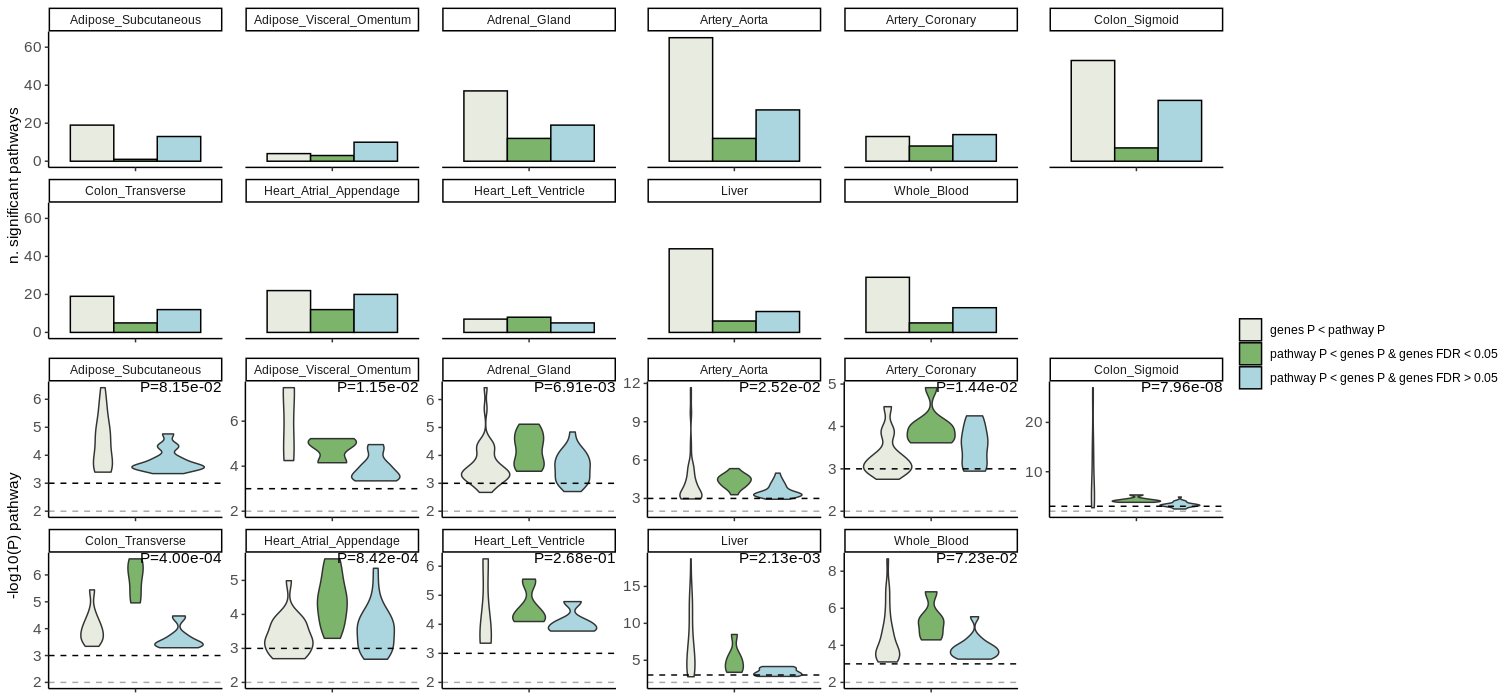

In [17]:
# tissue specific
options(repr.plot.width = 15, repr.plot.height = 7, repr.plot.res = 100)

pl_npath <- plot_classPath(path_sign = path_complete, gene_tot = tscore, id_pval = 13, id_pval_gene = 8, pval_FDR = pval_FDR, 
               fold = paste0(out_fold, '/tissueSpec_'), pheno = pheno, tissue_type = 'specific', width_pl = 13, height_pl = 7)

pl_npath$pl
# number/percentage of pathway class per tissue
table(pl_npath$df$tissue, pl_npath$df$class)
table(pl_npath$df$tissue, pl_npath$df$class)/rowSums(table(pl_npath$df$tissue, pl_npath$df$class))
table(pl_npath$df$tissue, pl_npath$df$class == 'genes P < pathway P')/rowSums(table(pl_npath$df$tissue, pl_npath$df$class == 'genes P < pathway P'))



gene P < SNPs P & SNPs FDR < 0.05 gene P < SNPs P & SNPs FDR > 0.05 
                               28                                71 
                  SNPs P < gene P 
                              284 


gene P < SNPs P & SNPs FDR < 0.05 gene P < SNPs P & SNPs FDR > 0.05 
                       0.07310705                        0.18537859 
                  SNPs P < gene P 
                       0.74151436 

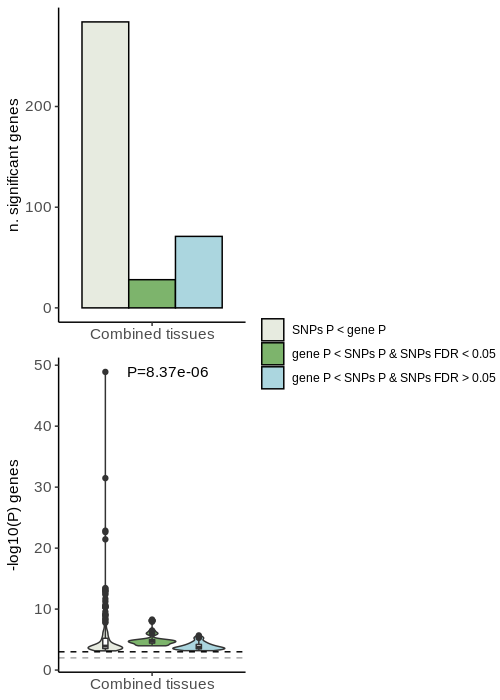

In [18]:
###################################################################
### number of significant genes that have better sign than snps ###
###################################################################
options(repr.plot.width = 5, repr.plot.height = 7, repr.plot.res = 100)
width_pl = 5
height_pl = 7

# all tissues combined
fold = out_fold
tscore_withSNPs <- tscore %>% mutate(id = paste(ensembl_gene_id, tissue, sep = '_')) %>%
                          filter(CAD_HARD_BHcorr <= pval_FDR)
regSNPs_gwas <- regSNPs_gwas %>% mutate(id = paste(ensembl_gene_id, tissue, sep = '_'))
regSNPs_gwas_signGenes <- regSNPs_gwas %>% filter(id %in% tscore_withSNPs$id)
tscore_withSNPs$improvement_sign <- NA
tscore_withSNPs$improvement_min <- NA
tscore_withSNPs$min_pval_snps <- NA
tscore_withSNPs$no_sign_snps <- NA
tscore_withSNPs$no_sign_FDR_snps <- NA

for(i in 1:nrow(tscore_withSNPs)){
    
    id_tmp <- tscore_withSNPs$id[i]
    tmp <- regSNPs_gwas_signGenes[regSNPs_gwas_signGenes$id %in% id_tmp,]
    tscore_withSNPs$improvement_sign[i] <- all(tmp$P >= tscore_withSNPs$CAD_HARD_pval[i])
    tscore_withSNPs$improvement_min[i] <- min(tmp$P - tscore_withSNPs$CAD_HARD_pval[i])
    tscore_withSNPs$min_pval_snps[i] <- min(tmp$P)
    tscore_withSNPs$no_sign_snps[i] <- all(tmp$P > 5*10^-8)
    tscore_withSNPs$no_sign_FDR_snps[i] <- all(tmp$P_ADJ_BH > 0.05)

}
df_gene <- tscore_withSNPs
df_gene$impr <- as.numeric(df_gene$improvement_sign)

#tscore_withSNPs[tscore_withSNPs$improvement_sign,]

color_class <- c('#E7EBE0FF','#7DB46CFF', '#ABD6DFFF')
df_gene$class <- NA
df_gene$class_effect <- NA
df_gene$class[df_gene$impr == 0] <- 'SNPs P < gene P'
df_gene$class[df_gene$impr == 1 & df_gene$no_sign_FDR_snps] <- 'gene P < SNPs P & SNPs FDR > 0.05'
df_gene$class[df_gene$impr == 1 & !df_gene$no_sign_FDR_snps] <- 'gene P < SNPs P & SNPs FDR < 0.05'
table(df_gene$class)
table(df_gene$class)/nrow(df_gene)
df_gene$class <- factor(df_gene$class, levels = c('SNPs P < gene P', 'gene P < SNPs P & SNPs FDR < 0.05', 
                                                  'gene P < SNPs P & SNPs FDR > 0.05'))

df_gene$log10p <- -log10(df_gene[,8])
df_gene$tissue_tot = 'Combined tissues'
df_gene$tissue_tot = factor(df_gene$tissue_tot)
pval_pl <- formatC(kruskal.test(df_gene$log10p, g = df_gene$class)$p.value, format = "e", digits = 2)

pl1 <- ggplot(data = df_gene, aes(x = tissue_tot, fill = class))+
            geom_bar(stat = 'count', position = position_dodge(width = 0.9), color = 'black')+
            theme_classic()+ 
            ylab('n. significant genes')+
            scale_fill_manual(values = color_class)+
            theme(legend.position = 'right', axis.title.x = element_blank(),legend.title = element_blank(), axis.text = element_text(size = 11))

pl2 <- ggplot(df_gene, aes(x = tissue_tot, y = log10p, fill = class, group = class))+
          geom_violin(width=1, position = position_dodge(width = 0.9))+
          geom_boxplot(width=0.1,position = position_dodge(width = 0.9), fill = 'white')+
          geom_hline(linetype = 'dashed', yintercept = 3, color = 'black')+
          geom_hline(linetype = 'dashed', yintercept = 2, color = 'darkgrey')+
          ylab('-log10(P) genes')+
          scale_fill_manual(values = color_class)+
          annotate("text", x = 1.1, y = max(df_gene$log10p), label = sprintf('P=%s', pval_pl))+
          theme_classic()+
          theme(legend.position = 'right', axis.title.x = element_blank(), legend.title = element_blank(),  axis.text = element_text(size = 11))

tot_pl <- ggarrange(plotlist = list(pl1, pl2), ncol = 1, nrow = 2, align='v', common.legend = T, legend = 'right')
ggsave(filename = sprintf('%snGenes_class_and_Pdistribution_%s.png', fold, pheno), plot = tot_pl, width = width_pl, height = height_pl, dpi=500, device = 'png')
ggsave(filename = sprintf('%snGenes_class_and_Pdistribution_%s.pdf', fold, pheno), plot = tot_pl, width = width_pl, height = height_pl, device = 'pdf')
 
tot_pl

The majority of SNPs more significant than genes (74%, 284)


pathway P < SNPs P & SNPs FDR < 0.05 pathway P < SNPs P & SNPs FDR > 0.05 
                                  31                                  137 
                  SNPs P < pathway P 
                                 399 


pathway P < SNPs P & SNPs FDR < 0.05 pathway P < SNPs P & SNPs FDR > 0.05 
                          0.05467372                           0.24162257 
                  SNPs P < pathway P 
                          0.70370370 

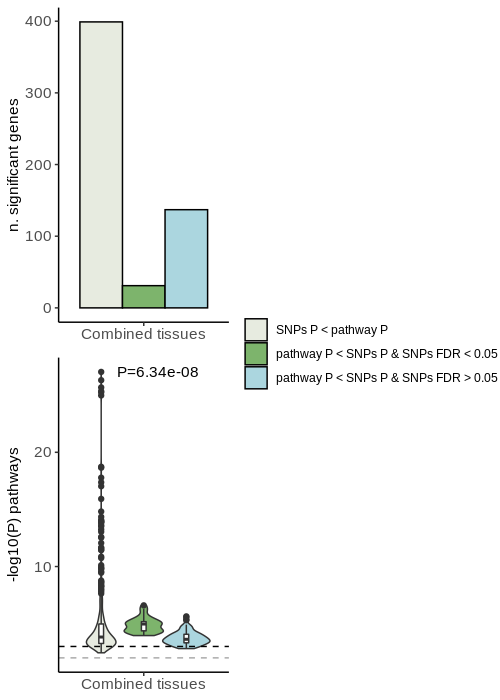

In [19]:
######################################################################
### number of significant pathways that have better sign than snps ###
######################################################################
options(repr.plot.width = 5, repr.plot.height = 7, repr.plot.res = 100)
width_pl = 5
height_pl = 7

# all tissues combined
fold = out_fold
path_withSNPs <- path_complete
path_withSNPs$improvement_sign <- NA
path_withSNPs$improvement_min <- NA
path_withSNPs$min_pval_snps <- NA
path_withSNPs$no_sign_snps <- NA
path_withSNPs$no_sign_FDR_snps <- NA

  
for(i in 1:nrow(path_withSNPs)){
    
    tissue_tmp <- path_withSNPs$tissue[i]
    genes_tmp <- path_withSNPs$genes_path[i]
    genes_tmp <- strsplit(genes_tmp, split = ',')[[1]]
    tmp <- regSNPs_gwas[regSNPs_gwas$external_gene_name %in% genes_tmp & regSNPs_gwas$tissue == tissue_tmp,]
    
    path_withSNPs$improvement_sign[i] <- all(tmp$P >= path_withSNPs$CAD_HARD_pval[i])
    path_withSNPs$improvement_min[i] <- min(tmp$P - path_withSNPs$CAD_HARD_pval[i])
    path_withSNPs$min_pval_snps[i] <- min(tmp$P)
    path_withSNPs$no_sign_snps[i] <- all(tmp$P > 5*10^-8)
    path_withSNPs$no_sign_FDR_snps[i] <- all(tmp$P_ADJ_BH > 0.05)

}
df_path <- path_withSNPs
df_path$impr <- as.numeric(df_path$improvement_sign)

color_class <- c('#E7EBE0FF','#7DB46CFF', '#ABD6DFFF')
df_path$class <- NA
df_path$class_effect <- NA
df_path$class[df_path$impr == 0] <- 'SNPs P < pathway P'
df_path$class[df_path$impr == 1 & df_path$no_sign_FDR_snps] <- 'pathway P < SNPs P & SNPs FDR > 0.05'
df_path$class[df_path$impr == 1 & !df_path$no_sign_FDR_snps] <- 'pathway P < SNPs P & SNPs FDR < 0.05'
table(df_path$class)
table(df_path$class)/nrow(df_path)
df_path$class <- factor(df_path$class, levels = c('SNPs P < pathway P', 'pathway P < SNPs P & SNPs FDR < 0.05', 
                                                  'pathway P < SNPs P & SNPs FDR > 0.05'))

df_path$log10p <- -log10(df_path[,13])
df_path$tissue_tot = 'Combined tissues'
df_path$tissue_tot = factor(df_path$tissue_tot)
pval_pl <- formatC(kruskal.test(df_path$log10p, g = df_path$class)$p.value, format = "e", digits = 2)

pl1 <- ggplot(data = df_path, aes(x = tissue_tot, fill = class))+
            geom_bar(stat = 'count', position = position_dodge(width = 0.9), color = 'black')+
            theme_classic()+ 
            ylab('n. significant genes')+
            scale_fill_manual(values = color_class)+
            theme(legend.position = 'right', axis.title.x = element_blank(),legend.title = element_blank(), axis.text = element_text(size = 11))

pl2 <- ggplot(df_path, aes(x = tissue_tot, y = log10p, fill = class, group = class))+
          geom_violin(width=1, position = position_dodge(width = 0.9))+
          geom_boxplot(width=0.1,position = position_dodge(width = 0.9), fill = 'white')+
          geom_hline(linetype = 'dashed', yintercept = 3, color = 'black')+
          geom_hline(linetype = 'dashed', yintercept = 2, color = 'darkgrey')+
          ylab('-log10(P) pathways')+
          scale_fill_manual(values = color_class)+
          annotate("text", x = 1.1, y = max(df_path$log10p), label = sprintf('P=%s', pval_pl))+
          theme_classic()+
          theme(legend.position = 'right', axis.title.x = element_blank(), legend.title = element_blank(),  axis.text = element_text(size = 11))

tot_pl <- ggarrange(plotlist = list(pl1, pl2), ncol = 1, nrow = 2, align='v', common.legend = T, legend = 'right')
ggsave(filename = sprintf('%snPathways_class_and_Pdistribution_wrt_SNPs_%s.png', fold, pheno), plot = tot_pl, width = width_pl, height = height_pl, dpi=500, device = 'png')
ggsave(filename = sprintf('%snPathways_class_and_Pdistribution_wrt_SNPs_%s.pdf', fold, pheno), plot = tot_pl, width = width_pl, height = height_pl, device = 'pdf')
 
tot_pl


Same for pathways, the majority (70%, 399) include SNPs more significant singularly

In [20]:
# which pathways are composed of genes less sign that in turn are composed of snps less significant?
# significance increase with aggregation:

path_moresign_genes <- path_complete_ann %>% filter(class_pathway != 'genes P < pathway P')
path_moresign_genes$impr_allgenes_over_snps <- NA
for(i in 1:nrow(path_moresign_genes)){
    tissue_tmp <- path_moresign_genes$tissue[i]
    genes_tmp <- path_moresign_genes$genes_path[i]
    genes_tmp <- strsplit(genes_tmp, split = ',')[[1]]
    
    tscore_tmp <-  tscore[tscore$tissue == tissue_tmp & tscore$external_gene_name %in% genes_tmp, ]
    gwas_tmp <- regSNPs_gwas[regSNPs_gwas$external_gene_name %in% genes_tmp & regSNPs_gwas$tissue == tissue_tmp,]
    impr_sign_genes <- c()
    for(j in 1:nrow(tscore_tmp)){
        pval_gwas <- gwas_tmp$P[gwas_tmp$external_gene_name == tscore_tmp$external_gene_name[j]]
        impr_sign_genes <- c(impr_sign_genes, all(pval_gwas > tscore_tmp$CAD_HARD_pval[j]))
    }
    path_moresign_genes$impr_allgenes_over_snps[i] <- all(impr_sign_genes)
}
table(path_moresign_genes$impr_allgenes_over_snps)

path_moresign_genes[path_moresign_genes$impr_allgenes_over_snps,]


FALSE  TRUE 
  254     1 

path           ngenes_tscore ngenes_path mean_dev_geno sd_dev_geno 
161 phagocytic cup 2             14          0.03523684    7.156593e-05
    mean_test_dev_geno sd_test_dev_geno mean_gene_corr sd_gene_corr
161 0.02082694         0.003458004      -0.0002883155  NA          
    CAD_HARD_beta ⋯ CardioGram_se_beta CardioGram_z CardioGram_pval
161 0.0001814479  ⋯ 0.01927529         2.677894     0.007408659    
    CardioGram_pval_BHcorr CardioGram_Cochran_stat CardioGram_Cochran_pval
161 0.2395466              17.88863                0.0220771              
    CardioGram_model replicated class_pathway                         
161 fixed            TRUE       pathway P < genes P & genes FDR < 0.05
    impr_allgenes_over_snps
161 TRUE

In [21]:
# plot count table
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res = 100)

tab_count_path <- table(path_complete_ann$class_pathway, df_path$class)
tab_count_path
for(i in 1:3){
    colnames(tab_count_path)[i] <- gsub(" & ","\n", colnames(tab_count_path)[i])
    rownames(tab_count_path)[i] <- gsub(" & ","\n", rownames(tab_count_path)[i])
}

pdf(file = sprintf('%s/count_pathwayClass_genes_snps_based.pdf', out_fold), width = 4, height = 4, compress = F)
corrplot(tab_count_path,
             title = "",
             method = 'square', tl.srt=45, cl.align.text='c',
             tl.col="black",
             col = brewer.pal(n = 9, name = 'Blues'), cl.pos = 'n',
             addCoef.col = "black", na.label = 'square', na.label.col = 'darkgrey', 
             is.corr = F, number.cex=0.8, mar = c(0,0,5,0))
dev.off()


                                        
                                         SNPs P < pathway P
  genes P < pathway P                                   295
  pathway P < genes P & genes FDR < 0.05                 37
  pathway P < genes P & genes FDR > 0.05                 67
                                        
                                         pathway P < SNPs P & SNPs FDR < 0.05
  genes P < pathway P                                                       4
  pathway P < genes P & genes FDR < 0.05                                   22
  pathway P < genes P & genes FDR > 0.05                                    5
                                        
                                         pathway P < SNPs P & SNPs FDR > 0.05
  genes P < pathway P                                                      13
  pathway P < genes P & genes FDR < 0.05                                   20
  pathway P < genes P & genes FDR > 0.05                                  104

png 
  2

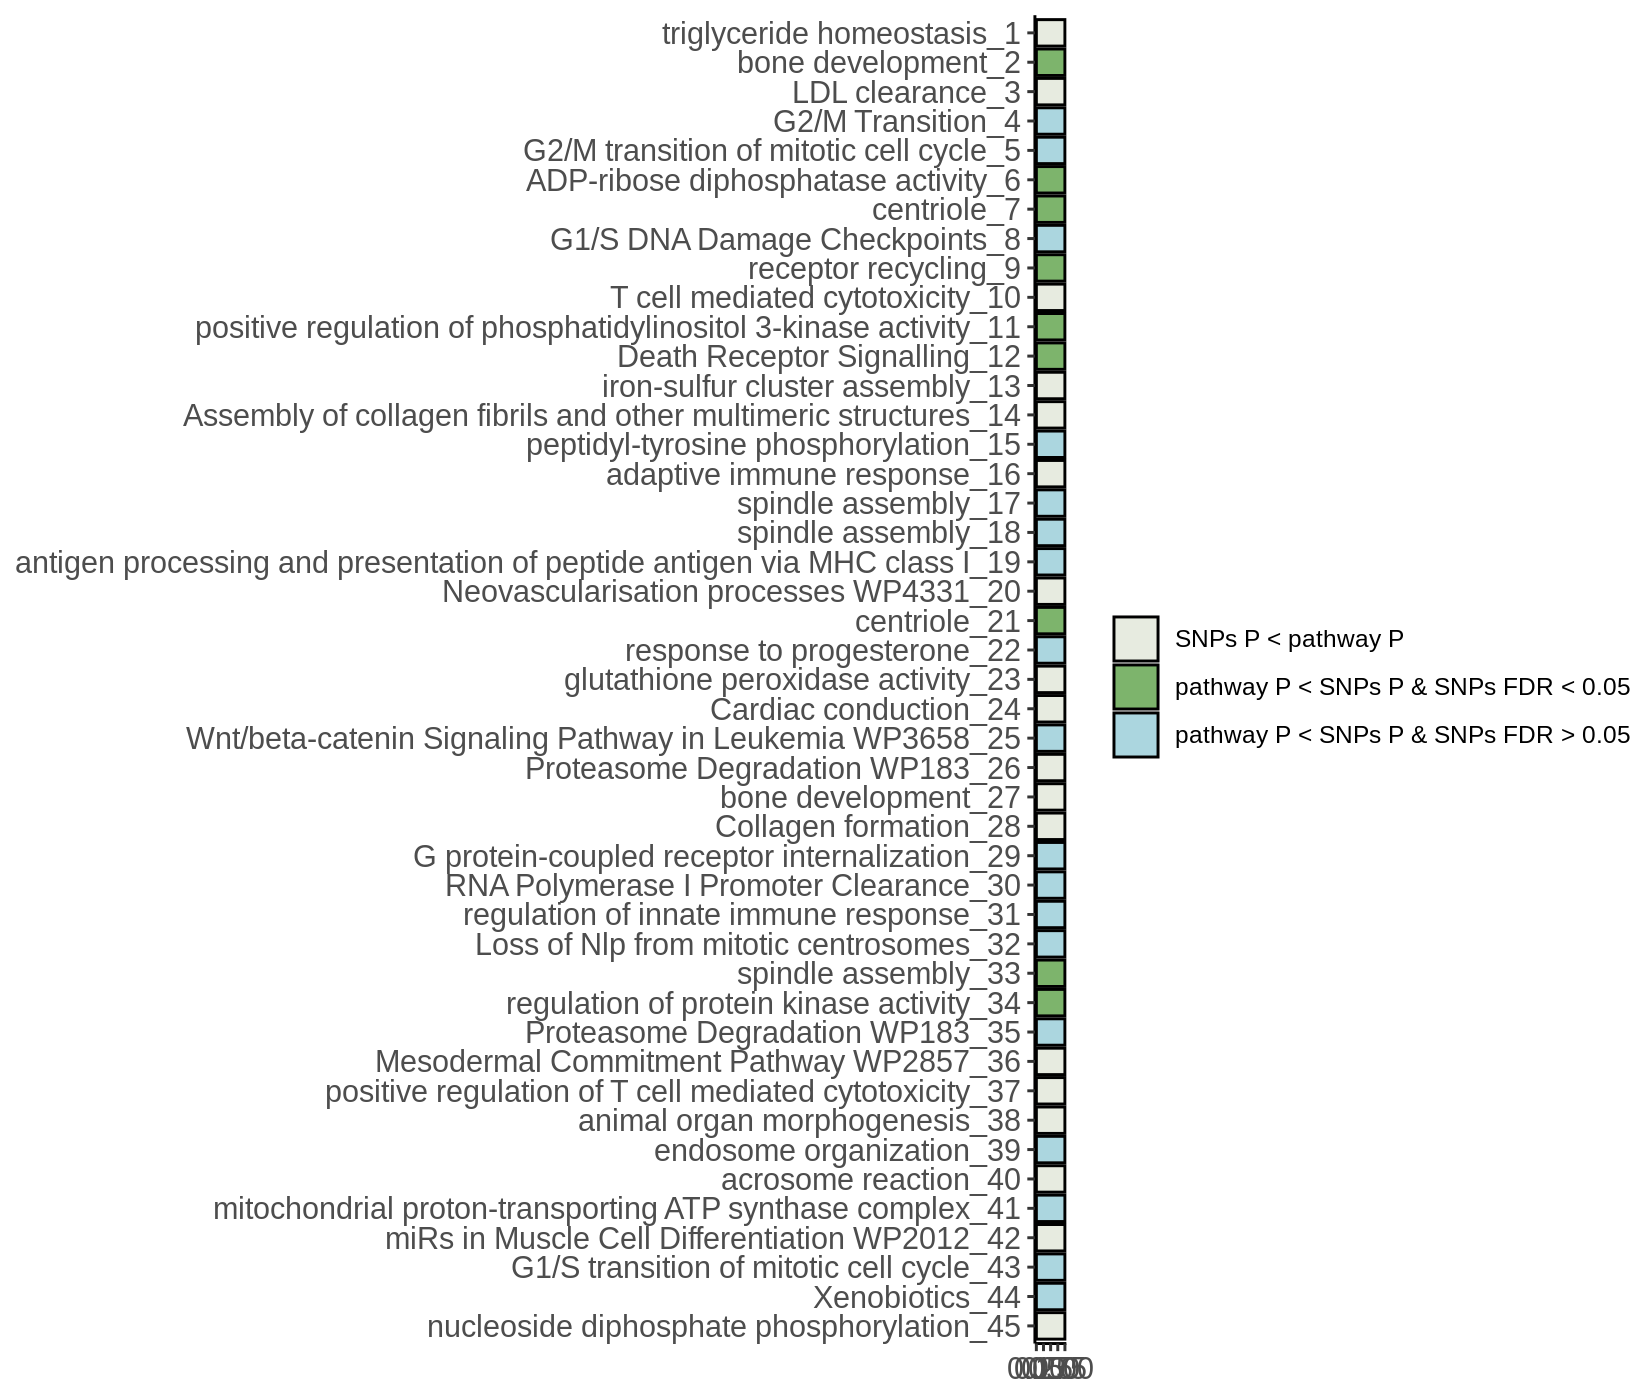

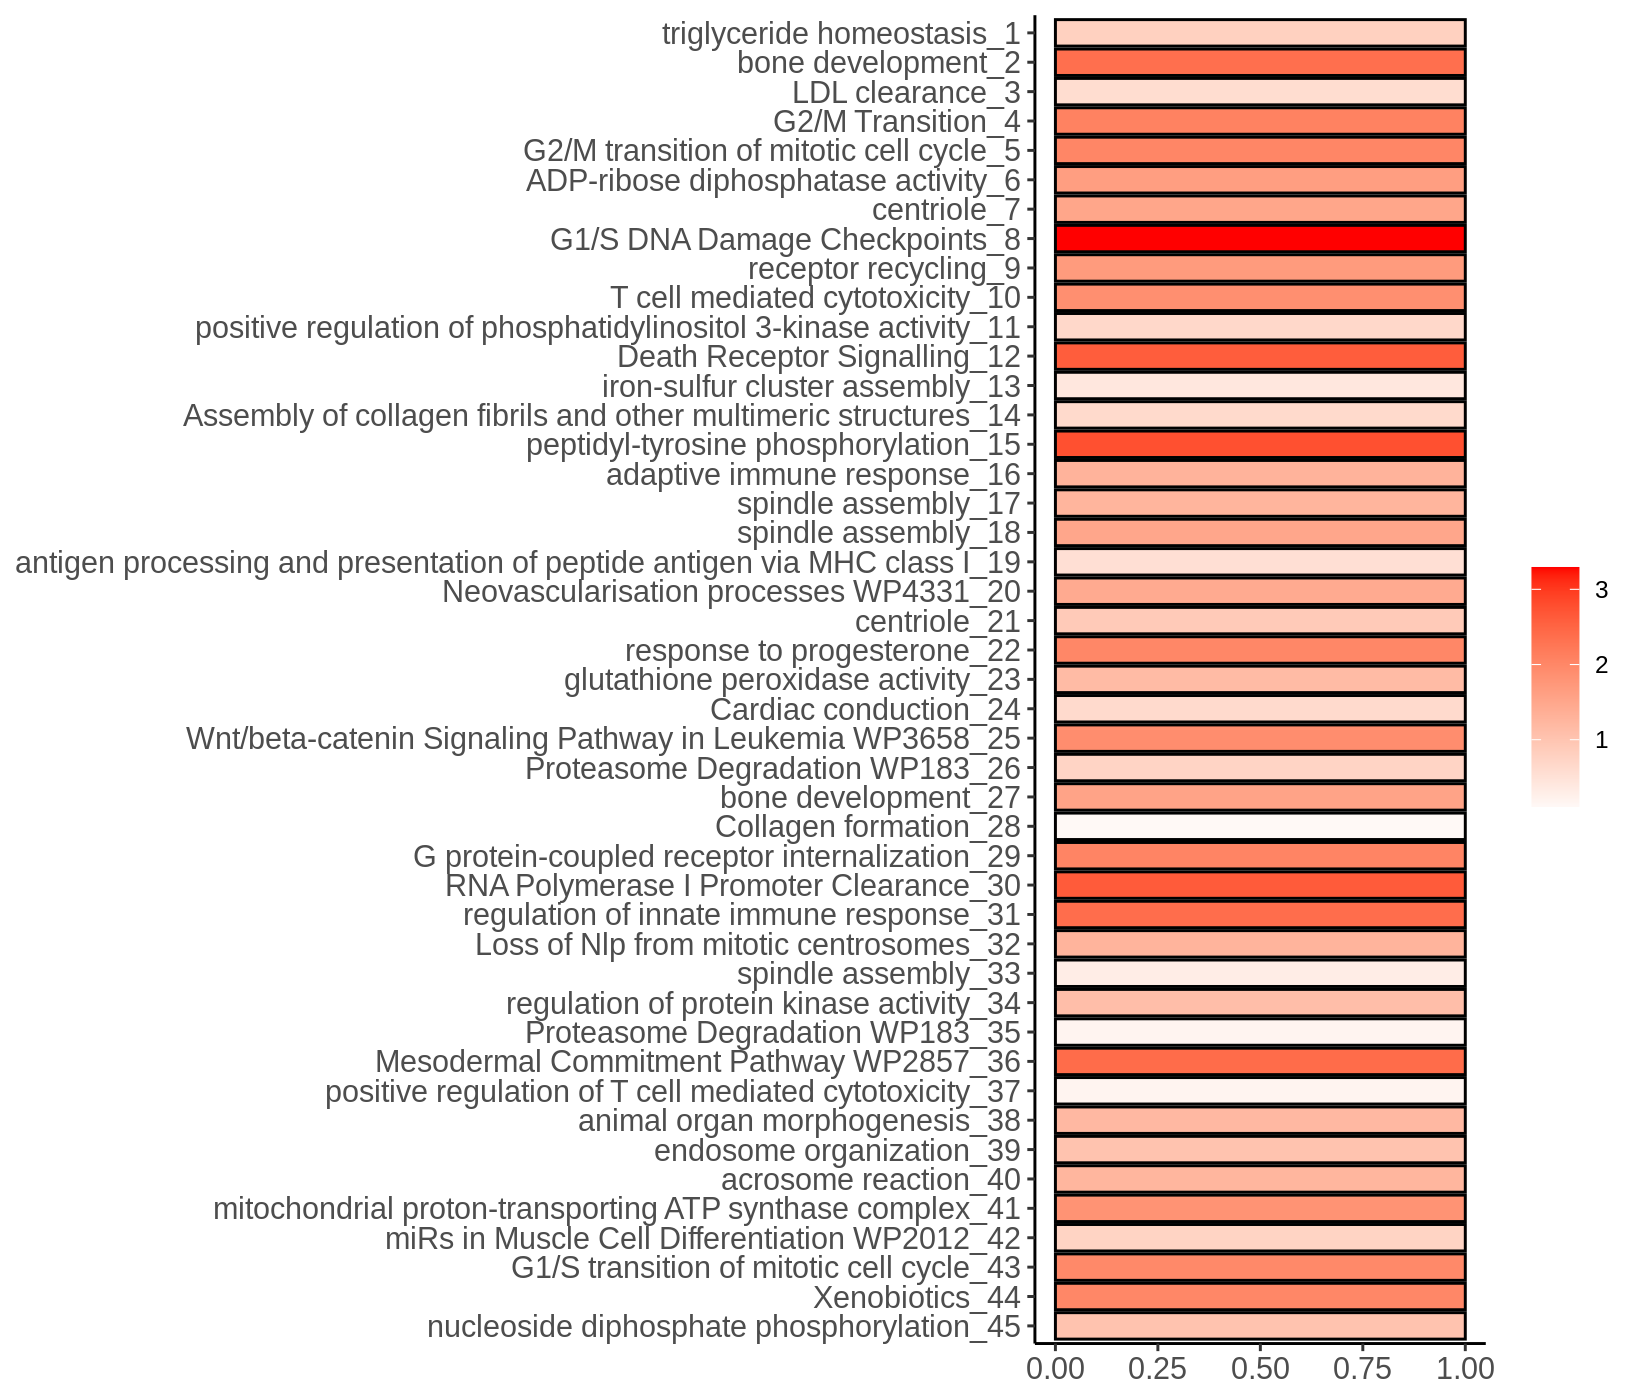

In [22]:
options(repr.plot.width = 8.2, repr.plot.height = 7, repr.plot.res = 200)

df_path$name <- paste(df_path$path, df_path$tissue, df_path$type_path, sep = '_') 
path_novel$name <- paste(path_novel$path, path_novel$tissue, path_novel$type_path, sep = '_') 

df_path_novel <- df_path[match(path_novel$name, df_path$name),] 

## add annotation
df <- df_path_novel[, c('path', 'class')]
df$n <- 1
df$name <- paste(df$path, 1:nrow(df), sep = '_')
df$name <- factor(df$name, levels = rev(df$name))
df$class <- factor(df$class, levels = c('SNPs P < pathway P', 'pathway P < SNPs P & SNPs FDR < 0.05', 
                                        'pathway P < SNPs P & SNPs FDR > 0.05'))
pl <- ggplot(data = df, mapping = aes(x = name, y = n, fill = class))+
  geom_bar(stat = 'identity', color = 'black')+
  theme_classic()+
  theme(legend.position = 'right', legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.title.y = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
    scale_fill_manual(values = c('#E7EBE0FF','#7DB46CFF', '#ABD6DFFF'))+
   coord_flip()

pl
ggsave(plot = pl, filename = sprintf('%s/novel_barplot_snpAnn.png', out_fold), width = 8.4, height = 7, dpi = 200)
ggsave(plot = pl, filename = sprintf('%s/novel_barplot_snpAnn.pdf', out_fold), width = 8.4, height = 7)

# plot diff
df <- path_novel[, c('path', 'diff')]
df$n <- 1
df$name <- paste(df$path, 1:nrow(df), sep = '_')
df$name <- factor(df$name, levels = rev(df$name))
pl <- ggplot(data = df, mapping = aes(x = name, y = n, fill = diff))+
  geom_bar(stat = 'identity', color = 'black')+ 
  theme_classic()+
  theme(legend.position = 'right', legend.title = element_blank(), 
        axis.title.x = element_blank(), axis.title.y = element_blank(),
        axis.text.y = element_text(size = 11), 
        axis.text.x = element_text(angle = 0, size = 11))+
   scale_fill_gradient2(low = 'blue', mid = 'white', high = 'red')+
   coord_flip()

pl
ggsave(plot = pl, filename = sprintf('%s/novel_barplot_diffAnn.png', out_fold), width = 4, height = 7, dpi = 200)
ggsave(plot = pl, filename = sprintf('%s/novel_barplot_diffAnn.pdf', out_fold), width = 4, height = 7)



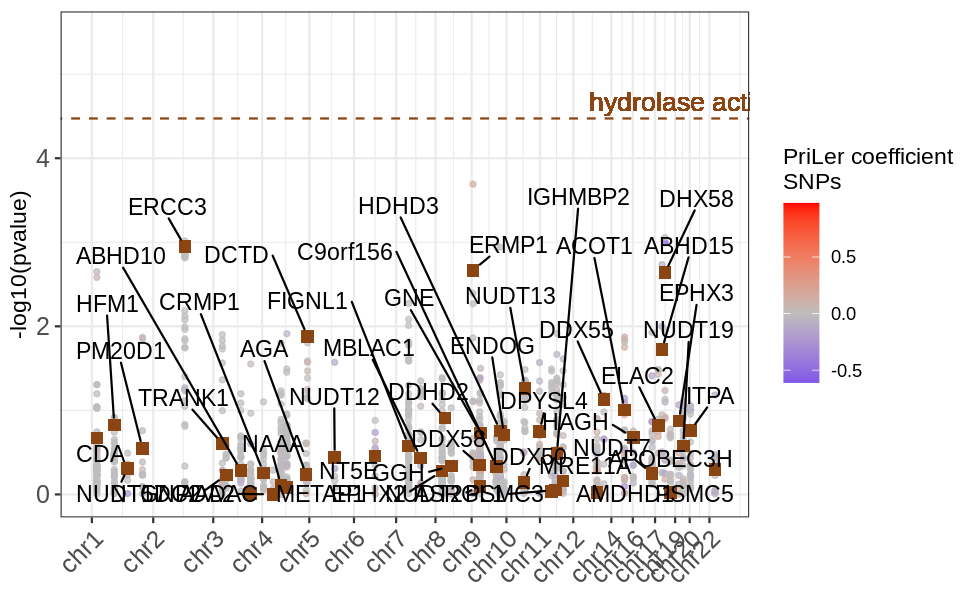

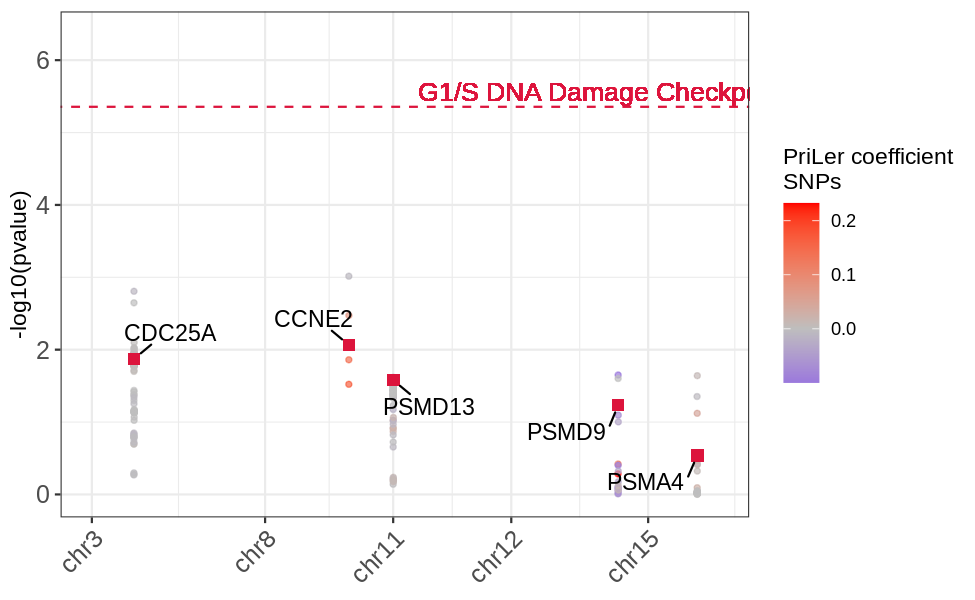

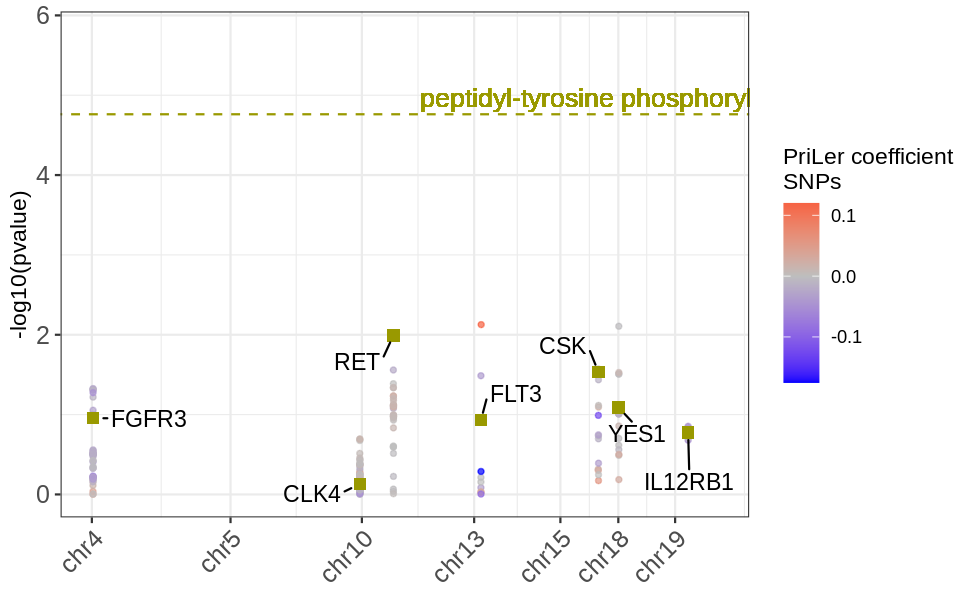

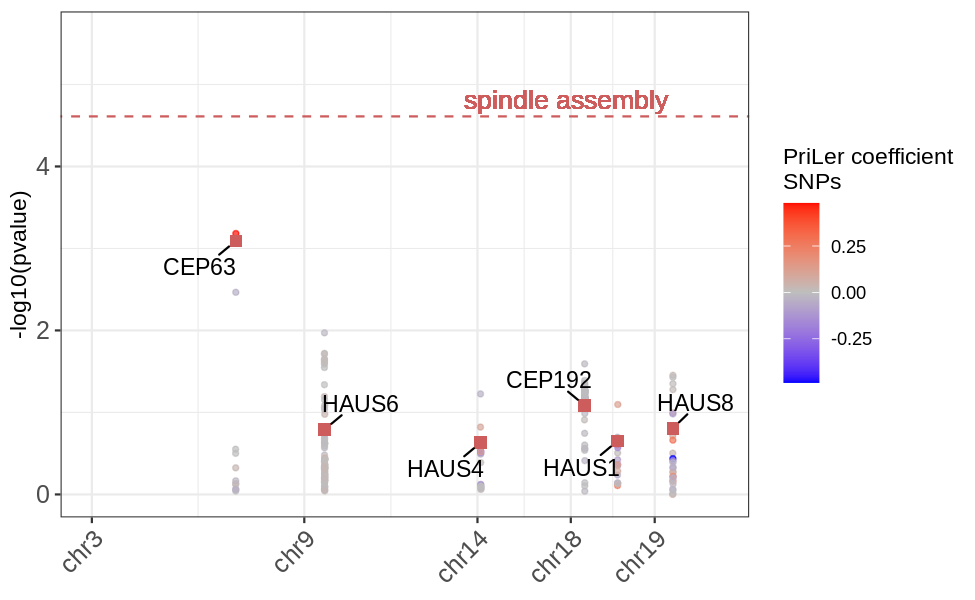

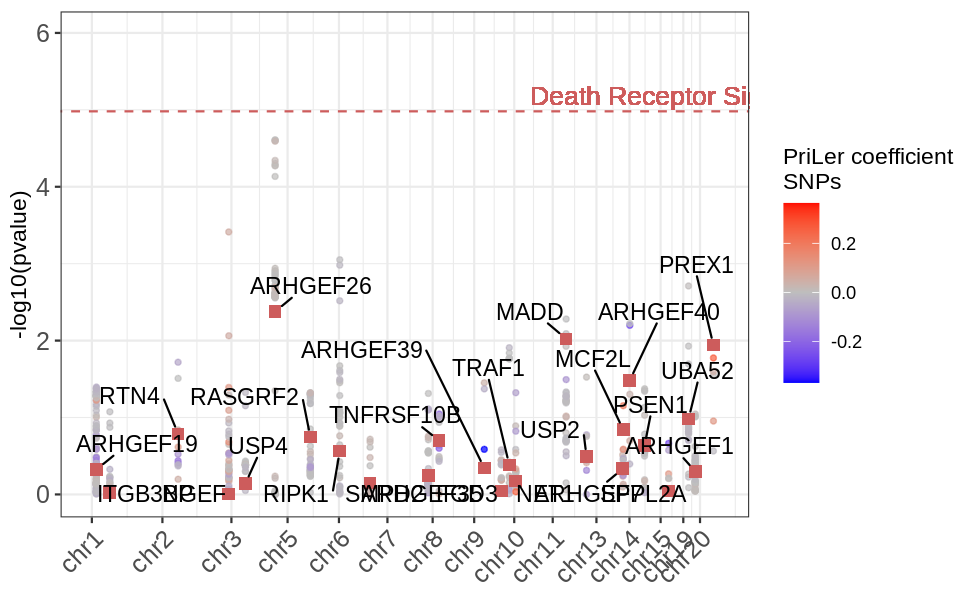

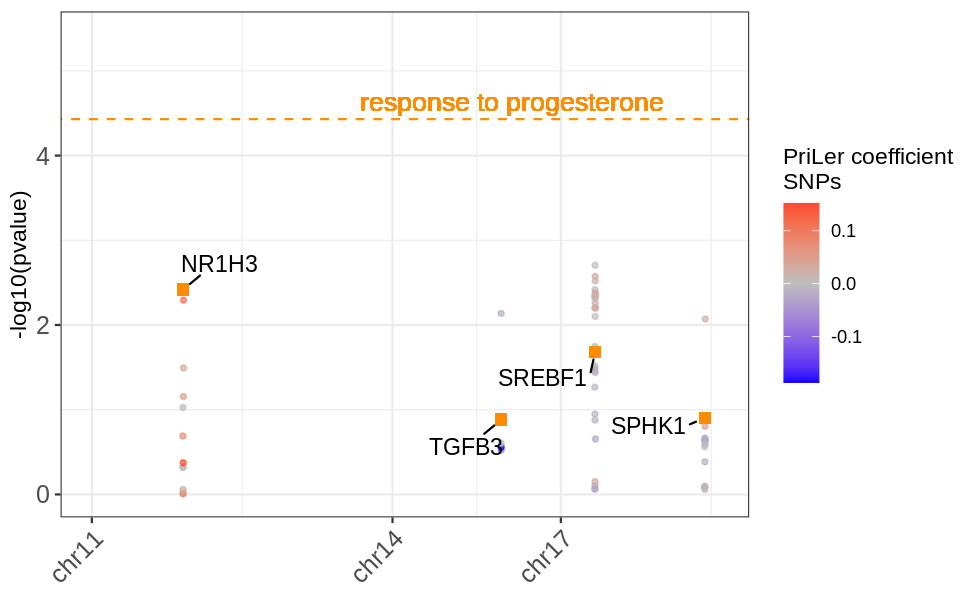

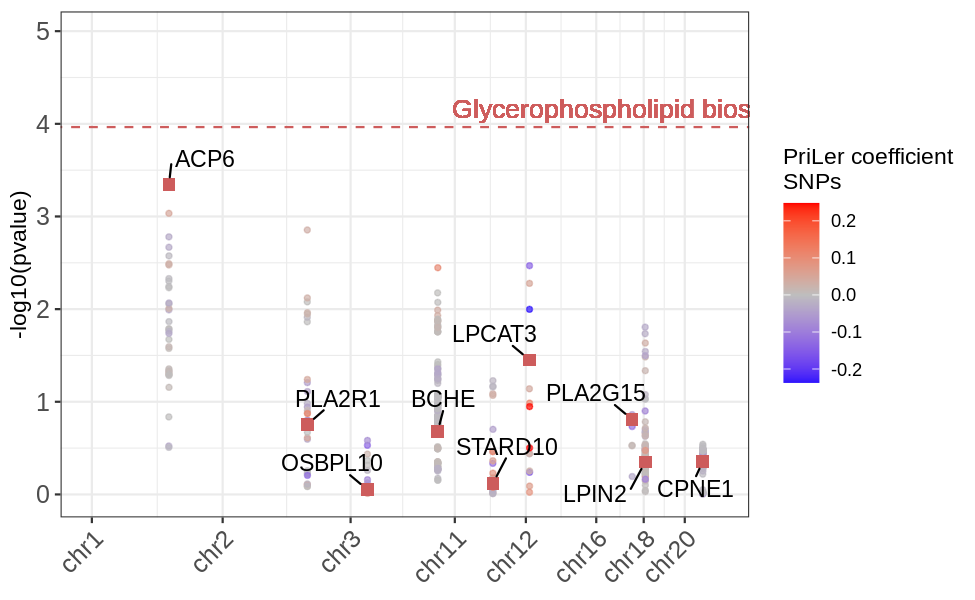

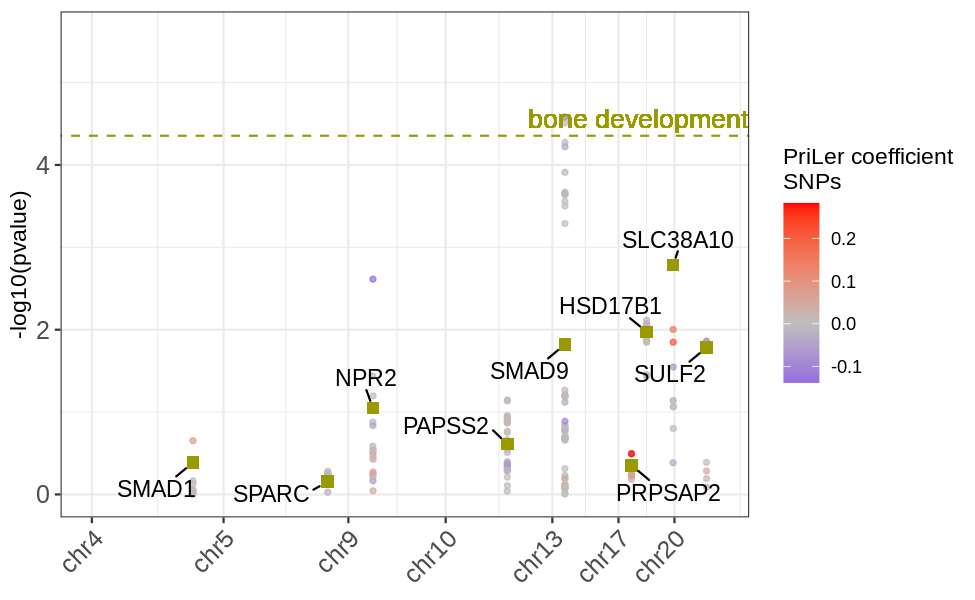

In [23]:
##############################################
### combined plot gwas -> genes -> pathway ###
##############################################
# specific for GWAS run on the same snps/sample set
# plot SNPs GWAS colored by reg Beta (only certain SNPs)
# add genes p-value (line with name on top on all gene lenght)
# add pathway significance (full line)
options(repr.plot.width = 6.5, repr.plot.height = 4, repr.plot.res = 150)
source(functR)
tissue <- 'Colon_Transverse'
pathway <- 'hydrolase activity'
color_t <- color_tissues$color[color_tissues$tissues == tissue]
file_snp_coord <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'


plot_snp_genes_path(tissue = tissue, pathway = pathway, color_t = color_t, 
                    path_df = path_complete, gene_df = tscore, 
                    snp_df = regSNPs_gwas, file_snp_coord = file_snp_coord, 
                    fold = out_fold)

tissue <- 'Heart_Atrial_Appendage'
pathway <- 'G1/S DNA Damage Checkpoints'
color_t <- color_tissues$color[color_tissues$tissues == tissue]
file_snp_coord <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'


plot_snp_genes_path(tissue = tissue, pathway = pathway, color_t = color_t, 
                    path_df = path_complete, gene_df = tscore, 
                    snp_df = regSNPs_gwas, file_snp_coord = file_snp_coord, 
                    fold = out_fold)


tissue <- 'Adipose_Subcutaneous'
pathway <- 'peptidyl-tyrosine phosphorylation'
color_t <- color_tissues$color[color_tissues$tissues == tissue]
file_snp_coord <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'


plot_snp_genes_path(tissue = tissue, pathway = pathway, color_t = color_t, 
                    path_df = path_complete, gene_df = tscore, 
                    snp_df = regSNPs_gwas, file_snp_coord = file_snp_coord, 
                    fold = out_fold)


tissue <- 'Artery_Aorta'
pathway <- 'spindle assembly'
color_t <- color_tissues$color[color_tissues$tissues == tissue]
file_snp_coord <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'


plot_snp_genes_path(tissue = tissue, pathway = pathway, color_t = color_t, 
                    path_df = path_complete, gene_df = tscore, 
                    snp_df = regSNPs_gwas, file_snp_coord = file_snp_coord, 
                    fold = out_fold)

tissue <- 'Artery_Aorta'
pathway <- 'Death Receptor Signalling'
color_t <- color_tissues$color[color_tissues$tissues == tissue]
file_snp_coord <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'


plot_snp_genes_path(tissue = tissue, pathway = pathway, color_t = color_t, 
                    path_df = path_complete, gene_df = tscore, 
                    snp_df = regSNPs_gwas, file_snp_coord = file_snp_coord, 
                    fold = out_fold)

tissue <- 'Whole_Blood'
pathway <- 'response to progesterone'
color_t <- color_tissues$color[color_tissues$tissues == tissue]
file_snp_coord <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'


plot_snp_genes_path(tissue = tissue, pathway = pathway, color_t = color_t, 
                    path_df = path_complete, gene_df = tscore, 
                    snp_df = regSNPs_gwas, file_snp_coord = file_snp_coord, 
                    fold = out_fold)

tissue <- 'Artery_Coronary'
pathway <- 'Glycerophospholipid biosynthesis'
color_t <- color_tissues$color[color_tissues$tissues == tissue]
file_snp_coord <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'

plot_snp_genes_path(tissue = tissue, pathway = pathway, color_t = color_t, 
                    path_df = path_complete, gene_df = tscore, 
                    snp_df = regSNPs_gwas, file_snp_coord = file_snp_coord, 
                   fold = out_fold)

tissue <- 'Adipose_Subcutaneous'
pathway <- 'bone development'
color_t <- color_tissues$color[color_tissues$tissues == tissue]
file_snp_coord <- 'CAD_UKBB/eQTL_PROJECT/INPUT_DATA_GTEx/GTEX_v6/Genotyping_data/Genotype_VariantsInfo_GTEx-PGCgwas-CADgwas-CADall-UKBB_'

plot_snp_genes_path(tissue = tissue, pathway = pathway, color_t = color_t, 
                    path_df = path_complete, gene_df = tscore, 
                    snp_df = regSNPs_gwas, file_snp_coord = file_snp_coord, 
                   fold = out_fold)

png 
  2

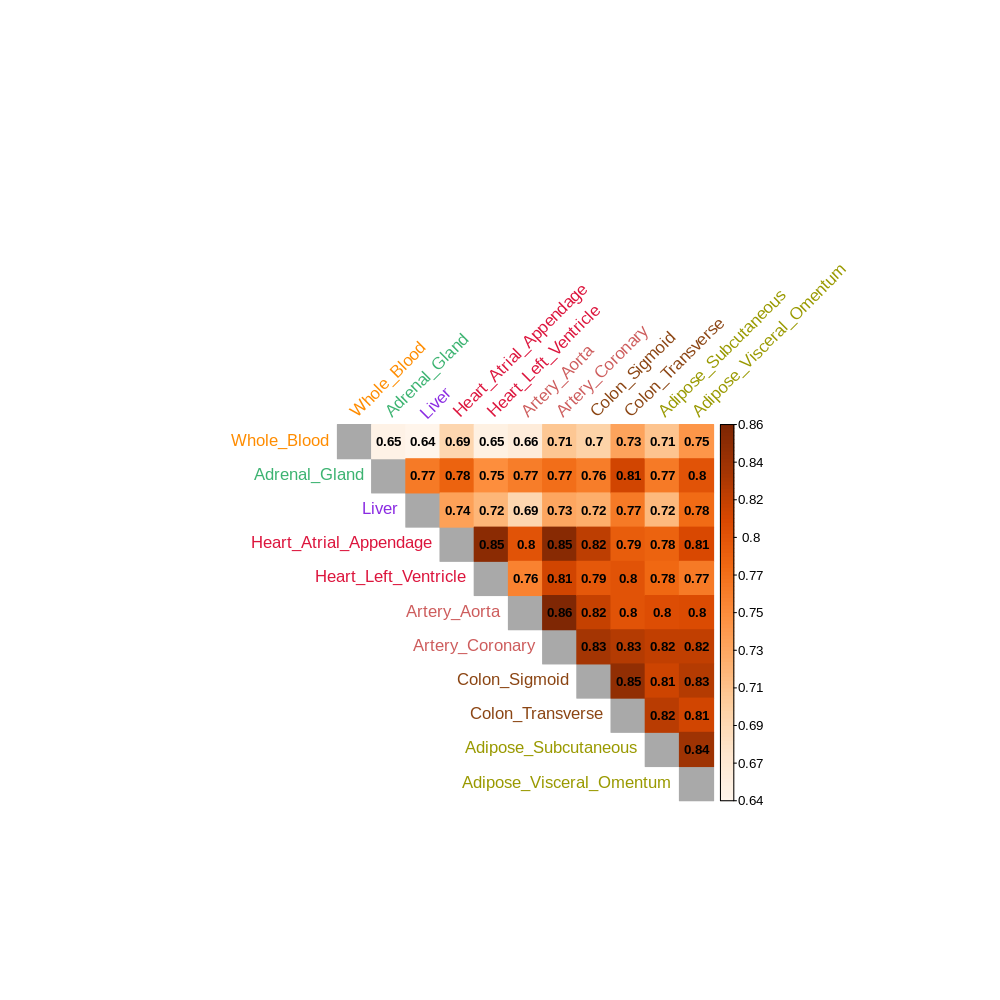

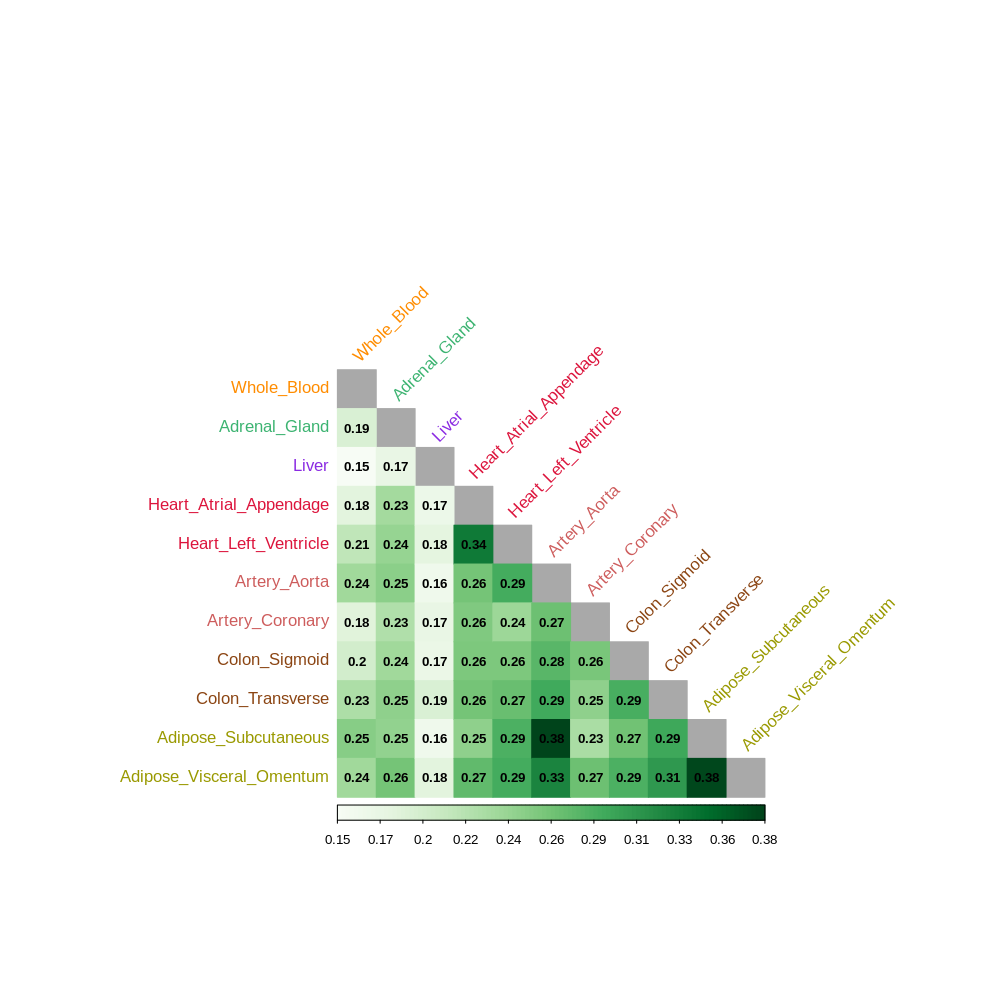

In [25]:
###########################################################
### spearman correlation and Jaccard index shared genes ###
###########################################################
# Fig. 1C
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)

tscore_cor <- create_cor(tissues_name = tissues, res = tscore, id_z = 7)
# save
pl_corr(tscore_cor, type_mat = 'tscore', type_dat = type_dat, tissues_name = tissues, df_color = color_tissues, outFold = out_fold, width_pl = 10, height_pl = 7)

# print plots corr + perc
col_val <- colorRampPalette(brewer.pal(9, "Oranges"))
ord <- corrMatOrder(tscore_cor$cor, order = "hclust", hclust.method = "ward.D")
newcolours <- color_tissues$color[match(tissues, color_tissues$tissues)][ord]
diag(tscore_cor$cor) <- NA
corrplot(tscore_cor$cor, type = "upper", order = "hclust", hclust.method = "ward.D", 
        tl.col = newcolours, col = col_val(100),
        method = "color", tl.srt = 45, cl.align.text = "c", addCoef.col = "black", 
        na.label = "square", na.label.col = "darkgrey", is.corr = FALSE, 
        number.cex = 0.8)

diag(tscore_cor$perc) <- NA
col_val <- colorRampPalette(brewer.pal(9, "Greens"))(100)
corrplot(tscore_cor$perc[ord, ord], type = "lower", tl.col = newcolours, 
        col = col_val, method = "color", tl.srt = 45, 
        cl.align.text = "c", addCoef.col = "black", na.label = "square", 
        na.label.col = "darkgrey", is.corr = F, number.cex = 0.8)



[1] "tscore"


tissue n_tot n_sign n_unique n_unique_sign
12 All    36424 383    13408    180

[1] "tscore not MHC"


tissue n_tot n_sign n_unique n_unique_sign
12 All    35571 303    13216    163

[1] "path-Reactome"


tissue n_tot n_sign n_unique n_unique_sign
12 All    9024  143    1435     102

[1] "path-GO"


tissue n_tot n_sign n_unique n_unique_sign
12 All    24620 351    4982     299

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


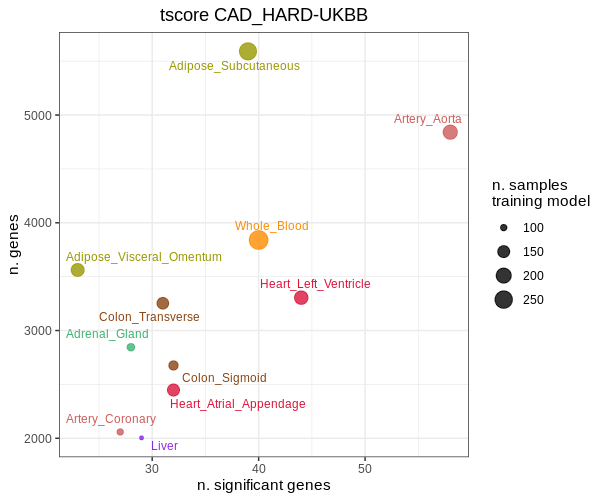

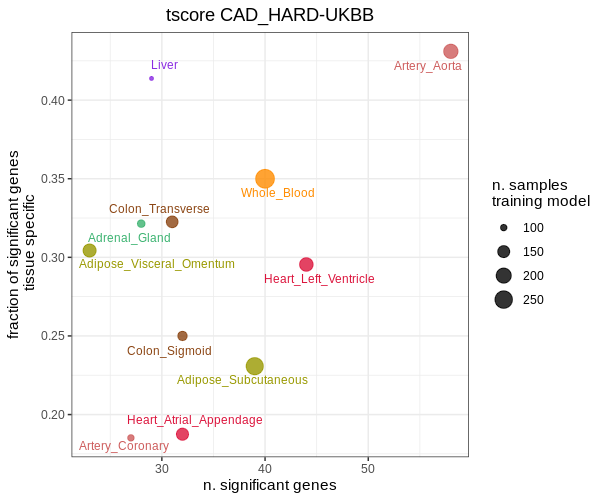

In [26]:
############################################################
### plot number of association per tissue vs specificity ###
############################################################
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 100)

tscore_nsgin <- creat_dfnsign(tissues_name = tissues, res = tscore, id_pval_corr = 10, 
                              pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 10)
pathR_nsgin <- creat_dfnsign(tissues_name = tissues, res = pathR, id_pval_corr = 15, 
                             pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 15)
pathGO_nsgin <- creat_dfnsign(tissues_name = tissues, res = pathGO, id_pval_corr = 17, 
                              pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 17)
tscore_red <- tscore
HLA_reg <- c(26000000, 34000000)
tscore_red <- tscore_red[!(tscore_red$chrom %in% 'chr6' & tscore_red$start_position <=HLA_reg[2] & tscore_red$start_position >= HLA_reg[1]) , ]
tscore_noMHC_nsgin <- creat_dfnsign(tissues_name = tissues, res = tscore_red, id_pval_corr = 10, pval_FDR = pval_FDR, df_color = color_tissues, id_pval_corr_tot = 12)

print('tscore')
tscore_nsgin$table[length(tissues)+1,]
print('tscore not MHC')
tscore_noMHC_nsgin$table[length(tissues)+1,]
print('path-Reactome')
pathR_nsgin$table[length(tissues)+1,]
print('path-GO')
pathGO_nsgin$table[length(tissues)+1,]

# save
pl <- pl_number_function(df = tscore_nsgin$plot, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

# plot
pl$ngen
pl$frac




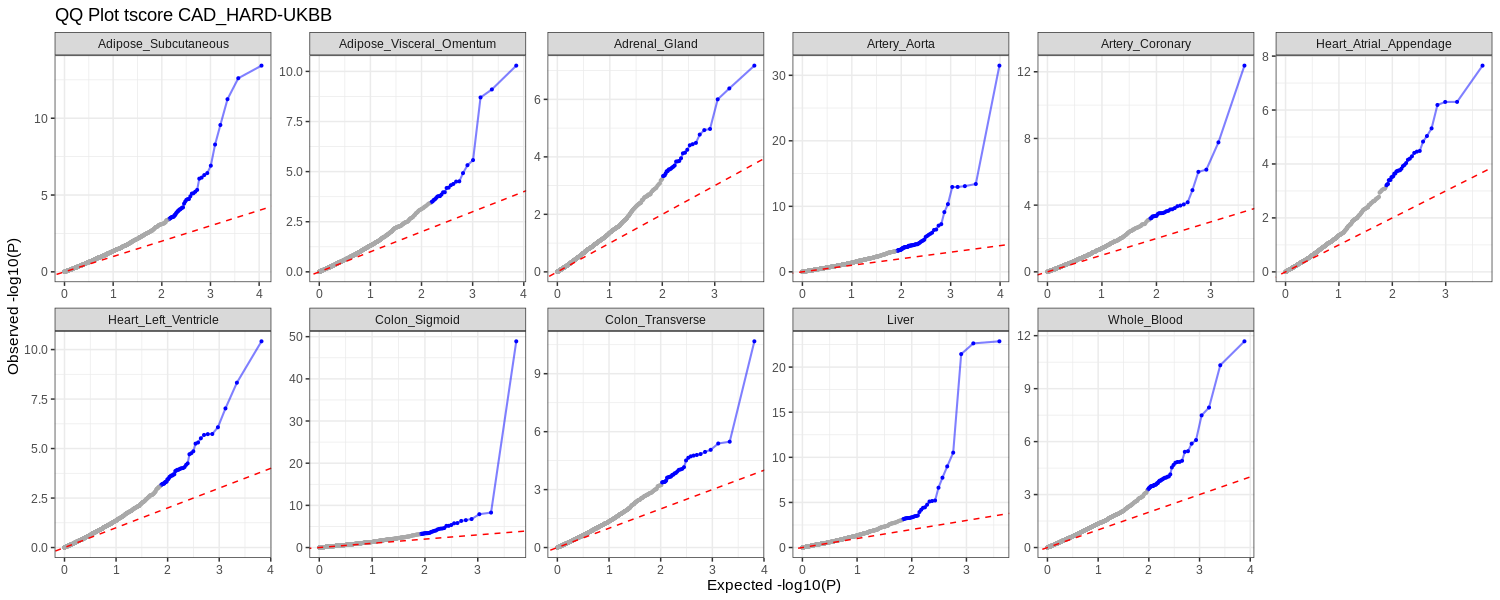

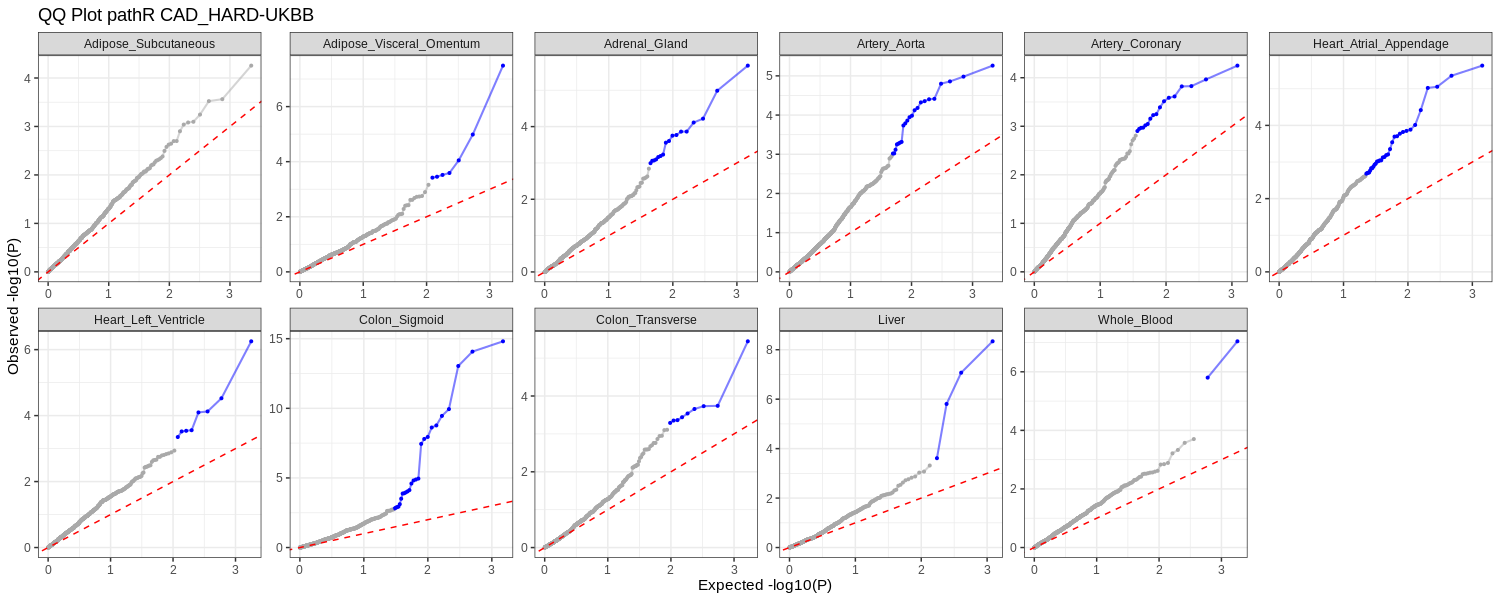

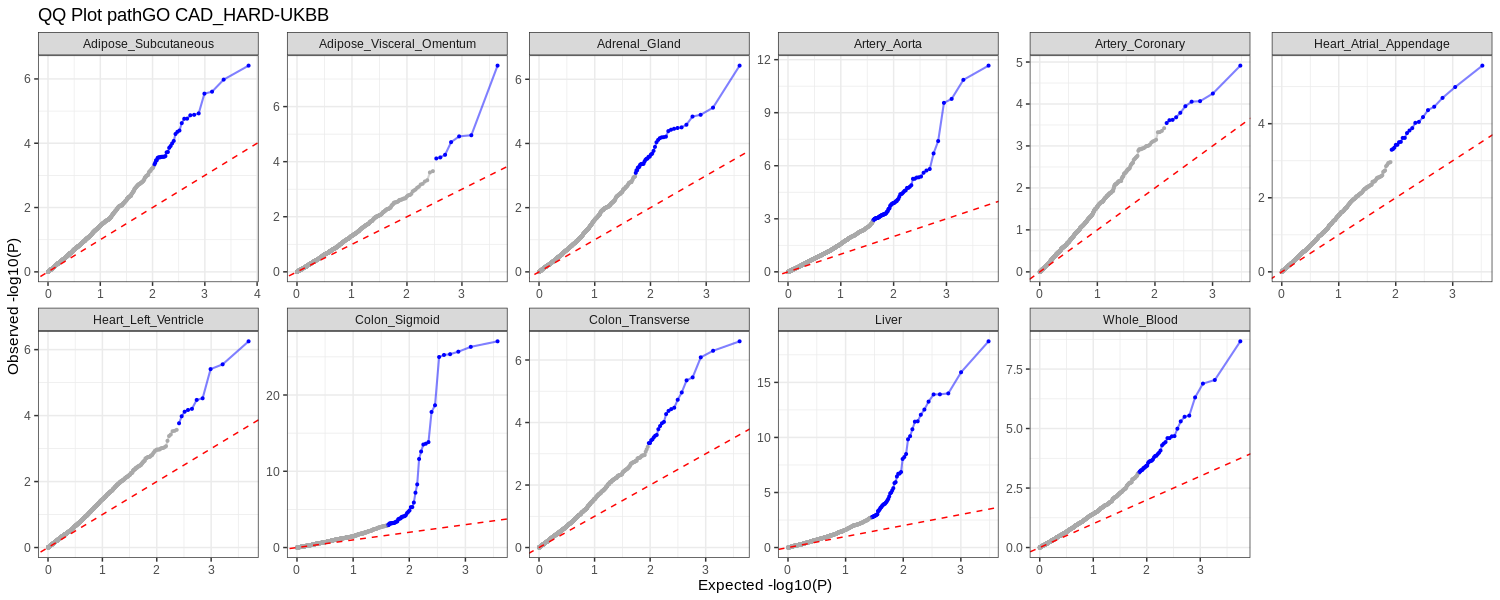

In [27]:
####################################
### plot qq-plot tissue specific ###
####################################
options(repr.plot.width = 15, repr.plot.height = 6, repr.plot.res = 100)

# tscore
res <- qq_plot_tissues(data = tscore, color_tissues = color_tissues, id_pval = 8, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'tscore', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path Reactome
res <- qq_plot_tissues(data = pathR, color_tissues = color_tissues, id_pval = 13, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathR', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl
# path GO
res <- qq_plot_tissues(data = pathGO, color_tissues = color_tissues, id_pval = 15, 
                pval_FDR = pval_FDR, outFold = out_fold, type_mat = 'pathGO', 
                type_dat = type_dat, width_plot = 12, height_plot = 6)
#res$genomic_infl
res$qq_pl



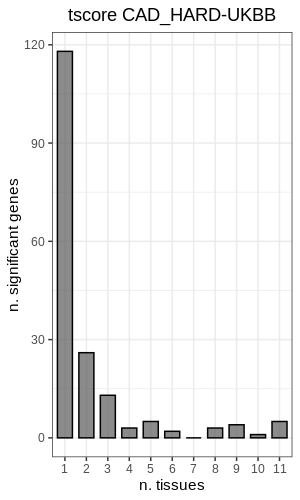

In [28]:
##################################################
### plot number of genes per number of tissues ###
##################################################
# Fig. 1B
options(repr.plot.width = 3, repr.plot.height = 5, repr.plot.res = 100)

tscore_nsgin_tissue <- creat_dfnsign_tissueSpec(tissues_name = tissues, res = tscore, id_pval_corr = 10, 
                                                pval_FDR = pval_FDR)
# save
pl <- pl_numberSpec_function(df = tscore_nsgin_tissue, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

# plot
pl

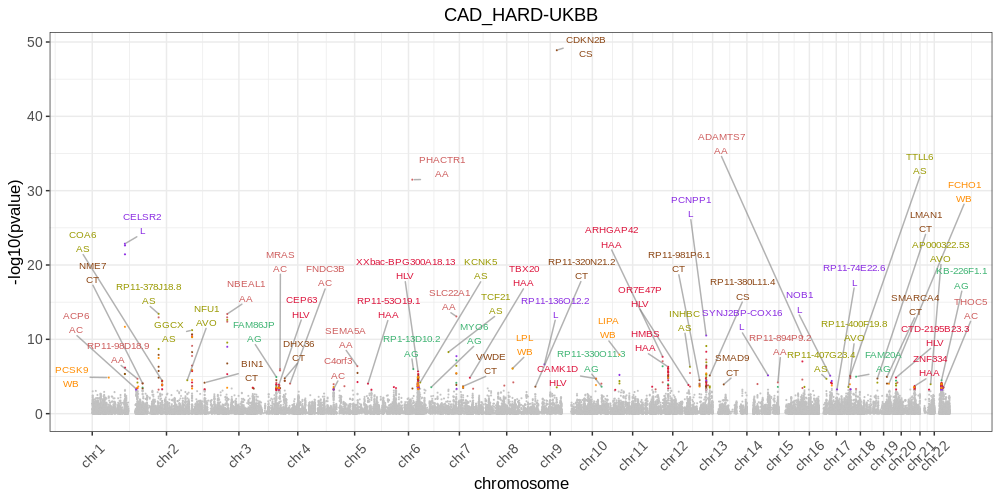

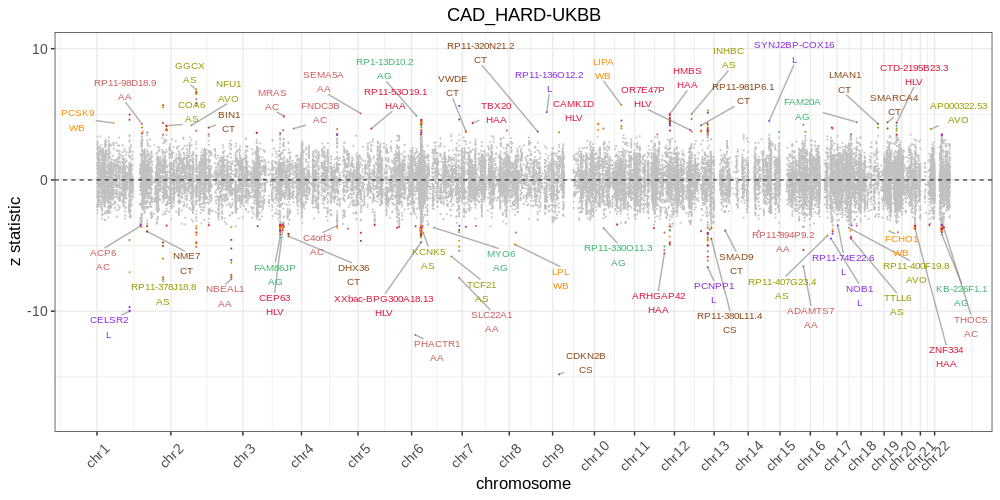

In [29]:
############################
### manhattan plot genes ###
############################
# Fig. 1A
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 100)
source(functR)

n_sign <- 25
convert_tissue_name <- function(vect_name){
  vect_name[vect_name %in% 'Liver'] <- 'L'
  vect_name[vect_name %in% 'Colon_Transverse'] <- 'CT'
  vect_name[vect_name %in% 'Colon_Sigmoid'] <- 'CS'
  vect_name[vect_name %in% 'Heart_Left_Ventricle'] <- 'HLV'
  vect_name[vect_name %in% 'Heart_Atrial_Appendage'] <- 'HAA'
  vect_name[vect_name %in% 'Whole_Blood'] <- 'WB'
  vect_name[vect_name %in% 'Artery_Aorta'] <- 'AA'
  vect_name[vect_name %in% 'Artery_Coronary'] <- 'AC'
  vect_name[vect_name %in% 'Adipose_Subcutaneous'] <- 'AS'
  vect_name[vect_name %in% 'Adipose_Visceral_Omentum'] <- 'AVO'  
  vect_name[vect_name %in% 'Adrenal_Gland'] <- 'AG'
  return(vect_name)
}
tissues_short <- convert_tissue_name(tissues)
tscore_short <- tscore 
tscore_short$tissue <- convert_tissue_name(tscore_short$tissue)
color_tissues_short <- color_tissues
color_tissues_short$tissues <- convert_tissue_name(color_tissues_short$tissues)

# for each tissue keep name of the 20 most significant genes
tscore_df <- create_df_manhattan_plot(tissues_name = tissues_short, res = tscore_short, id_pval = 8, 
                                      pval_FDR = pval_FDR, df_color = color_tissues_short, id_name = 2, 
                                      n_sign = n_sign, gene = T)
# include only 1 gene per locus
new_list <- tscore_df$df[tscore_df$df$sign_name == 'yes', ]
dist_mat <- as.matrix(dist(new_list$id_pos, method = 'manhattan'))
keep_t <- new_list$name
# recursevly until no intersection
tmp <- new_list
while(any(dist_mat[upper.tri(dist_mat)] < 3)){
  
  t_list <- apply(dist_mat, 1, function(x) x < 3)
  len_t <- c()
  keep_t <- c()
  for(j in 1:nrow(t_list)){
    tmp_sel <-  new_list[new_list$name %in% tmp$name[t_list[j,]],]
    tmp_sel <- tmp_sel[!tmp_sel$name %in% len_t, ]
    len_t <- unique(c(len_t, tmp_sel$name))
    keep_t <- unique(c(keep_t, tmp_sel$name[which.max(tmp_sel$pval_tr)]))
  }
  
  tmp <- tmp[tmp$name %in% keep_t, ]
  dist_mat <- as.matrix(dist(tmp$id_pos,method = 'manhattan'))
  
}
tscore_df$df$sign_name[tscore_df$df$sign_name == 'yes' & !tscore_df$df$name %in% tmp$name] <- 'no'
tscore_df$df$name[tscore_df$df$sign_name == 'no'] <- ''

# save
pl_tot <- pl_manhattan_function(data_input = tscore_df, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)
# plot
pl_tot$manhattan_pl
pl_tot$zstat_pl

# to save
pl_tot <- pl_manhattan_forpubl_function(data_input = tscore_df, type_mat = 'tscore', outFold = out_fold, type_dat = type_dat)

                  
                  

In [30]:
##############################################
### barplot selection significant pathways ###
##############################################
# Fig. 1D
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 100)

keep_path_file <- 'CAD_UKBB/eQTL_PROJECT/OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/keep_path_CAD_plot.csv'

pathR$type <- 'Reactome'
pathGO$type <- 'GO'
common_h <- intersect(colnames(pathR), colnames(pathGO))
tot_path <- rbind(pathR[, match(common_h, colnames(pathR))], pathGO[, match(common_h, colnames(pathGO))])

tmp_path <- read.csv(keep_path_file, h=T, stringsAsFactors = F)
tmp_path <- apply(tmp_path, 1, function(x) paste0(x, collapse = '_'))
tot_path_id <- apply(tot_path[, c('path', 'tissue', 'type')], 1, function(x) paste0(x, collapse = '_'))
best_path <- tot_path[match(tmp_path, tot_path_id), ]

best_path$logpval <-  -log10(best_path[, 13]) 
best_path$zstat <- best_path[, 12]
# save
pl <- plot_best_path(best_res = best_path, color_tissues = color_tissues, title_plot = pheno, type_mat = 'path', 
               outFold = out_fold, type_dat = type_dat, tissues = tissues, height_plot = 7, width_plot = 10, 
               id_pval = 13)
# plot
pl$pl_pval
pl$pl_zstat


ERROR: Error in plot_best_path(best_res = best_path, color_tissues = color_tissues, : unused argument (title_plot = pheno)


In [ ]:
######################################
### annotate genes by drug targets ###
######################################

options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 100)
library(drugbankR)
drugbank_genes <- 'refData/drugBank/All_geneTargets_enzymes.txt'
df <- queryDB(type = "getAll", db_path=sprintf("%sdrugbank_5.1.7.db", 'refData/drugBank/'))
id_CAD = unique(c(grep("artery", df$`mechanism-of-action`), grep("artery", df$indication)))
name_CAD <- unique(df[id_CAD, "drugbank-id"])

genes_sign <- unique(tscore_complete$external_gene_name)
genes_new <- unique(tscore_complete$external_gene_name[!tscore_complete$best_GWAS_signBH])
db_genes <- fread(drugbank_genes, h=T, stringsAsFactors = F, data.table = F)

db_genes_sign <- db_genes[db_genes$gene %in% genes_new,]
db_genes_sign <- db_genes_sign[order(db_genes_sign$gene), ]

# create 0-1 matrix drugs x targets
db_drug_name <- db_genes_sign[!duplicated(db_genes_sign$id), 1:2]
drug_gene_mat <- matrix(0,nrow = nrow(db_drug_name), ncol = length(unique(db_genes_sign$gene)))
rownames(drug_gene_mat) <- paste0(db_drug_name$drug, ' (', db_drug_name$id, ')')
colnames(drug_gene_mat) <- unique(db_genes_sign$gene)
for(i in 1:nrow(db_drug_name)){
    id <- colnames(drug_gene_mat) %in% db_genes_sign$gene[db_genes_sign$id == db_drug_name$id[i]]
    gene_type <- sapply(which(id), function(x) db_genes_sign$class[db_genes_sign$id == db_drug_name$id[i] & db_genes_sign$gene == colnames(drug_gene_mat)[x]])
    drug_gene_mat[i, id] <- gene_type
}
#drug_gene_mat
                        
# plot 
db_genes_sign$new_name <- paste0(db_genes_sign$drug, ' (', db_genes_sign$id, ')') 
db_genes_sign$new_name <- factor(db_genes_sign$new_name, levels = rev(unique(db_genes_sign$new_name)))
db_genes_sign$type <- NA
db_genes_sign$type[db_genes_sign$class == 'E'] <- 'Enzyme'
db_genes_sign$type[db_genes_sign$class == 'TR'] <- 'Transporters'           
db_genes_sign$type[db_genes_sign$class == 'T'] <- 'Target'
db_genes_sign$type <- factor(db_genes_sign$type, levels = c('Target', 'Transporters', 'Enzyme'))

pl <- ggplot(db_genes_sign, aes(gene, new_name)) + 
            geom_tile(aes(fill = type), colour = "black") + 
            theme_minimal()+
            theme(axis.title = element_blank(), axis.text = element_text(color = 'black'), 
                 axis.text.x = element_text(angle = 45, hjust = 1), legend.position = 'bottom')+
            scale_fill_manual(values=c("#D9514EFF", "#2A2B2DFF", "#2DA8D8FF"))
pl
# save
ggsave(filename = sprintf('%sNewGenes_%s_DrugBank_interactions.png', out_fold, pheno), plot = pl, width = 5, height = 5, dpi = 500)
ggsave(filename = sprintf('%sNewGenes_%s_DrugBank_interactions.pdf', out_fold, pheno), plot = pl, width = 5, height = 5, compress = F)
  